In [1]:
# === SETUP: Run this first! ===
import os
import sys

# Change to project root and add to Python path
notebook_dir = os.getcwd()
project_root = os.path.dirname(notebook_dir)  # Goes up one level from 'notebooks/'
os.chdir(project_root)
sys.path.insert(0, project_root)

print(f"Project root: {project_root}")
print(f"tsnn module path: {os.path.join(project_root, 'tsnn')}")

Project root: /Users/gremy/Code/TSNN-1
tsnn module path: /Users/gremy/Code/TSNN-1/tsnn


In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV, RidgeCV, LinearRegression
import torch
from torch.utils.data import Dataset, random_split
from torch.utils.data import DataLoader
import importlib
import sys
#sys.path.append('/Users/cyrilgarcia/notebooks/tsnn/')

import tsnn

from tsnn.generators import generators
from tsnn.benchmarks import benchmark_comparison, ml_benchmarks, torch_benchmarks
from tsnn import utils
import torch.nn.functional as F
import math
from typing import Optional
from tsnn.tstorch import transformers



plt.style.use('ggplot')

In [3]:
from dataclasses import dataclass
from torch import nn
device = 'mps'

In [4]:
from typing import Dict

# Summary

In this notebook we will run a lot of different comparisons of different models.

As a first basic setup, in the data we will vary the noise level and effets present, keep the dimensions of the data fixed for now.

Our main metric of performance will be the correlation IS and OOS of the model prediction to y_optimal. We will also try to optimize the training time.

# Test dataset

In [5]:
# We work with the following data.

In [6]:
def generate_synthetic_datasets(
    num_time_steps: int = 3000,
    num_time_series: int = 10,
    num_features: int = 10,
    low_corr: float = 0.1,
    high_corr: float = 0.2,
    pct_zero_corr: float = 0.5,
) -> Dict[str, "generators.Generator"]:
    """
    Generates 5 synthetic multivariate time series datasets with different
    types of cross-series dependencies.

    Returns
    -------
    dict
        Keys: "d_cond", "d_shift", "d_cs", "d_cs_shift", "d_all"
        Values: generators.Generator objects (already with .train and .test)
    """
    dic_data = {}

    # Helper to avoid repeating the same 10 lines
    def make_gen(split_conditional=0.0,
                 split_shift=0.0,
                 split_seasonal=0.0,
                 split_cs=0.0,
                 split_cs_shift=0.0):
        gen = generators.Generator(num_time_steps, num_time_series, num_features)
        gen.generate_dataset(
            pct_zero_corr=pct_zero_corr,
            split_conditional=split_conditional,
            split_shift=split_shift,
            split_seasonal=split_seasonal,
            split_cs=split_cs,
            split_cs_shift=split_cs_shift,
            low_corr=low_corr,
            high_corr=high_corr,
        )
        return gen

    # 1. Pure conditional (causal) dependence
    dic_data["d_cond"] = make_gen(split_conditional=1.0)

    # 2. Pure lagged (time-shifted) dependence
    dic_data["d_shift"] = make_gen(split_shift=1.0)

    # 3. Pure contemporaneous cross-sectional correlation
    dic_data["d_cs"] = make_gen(split_cs=1.0)

    # 4. Contemporaneous + lagged cross-series
    dic_data["d_cs_shift"] = make_gen(split_cs_shift=1.0)

    # 5. Equal mix of all four mechanisms
    dic_data["d_all"] = make_gen(
        split_conditional=0.25,
        split_shift=0.25,
        split_cs=0.25,
        split_cs_shift=0.25,
    )

    return dic_data

In [7]:
list_low_corr = [0.01, 0.025, 0.05, 0.1]
list_high_corr = [2*x for x in list_low_corr]

dic_data = {}

for i in range(len(list_low_corr)):
    name = "noise" + str(i+1)
    dic_data[name] = generate_synthetic_datasets(low_corr=list_low_corr[i], high_corr=list_high_corr[i])
    

In [8]:
dic_data.keys()

dict_keys(['noise1', 'noise2', 'noise3', 'noise4'])

In [9]:
# We will fix the above dataset for now.

# First test on the data with NN1

In [10]:
# Here let's take the basic neural network and run it on all the data above.

In [11]:
class GlobalMLP(nn.Module):
    def __init__(
        self,
        n_ts,          # N
        n_f,           # F
        n_rolling,     # T
        hidden_dim=512,
        num_layers=4,
        dropout=0.1,
    ):
        super().__init__()
        
        input_dim = n_rolling * n_ts * n_f
        
        layers = []
        dim = input_dim
        for i in range(num_layers):
            layers.append(nn.Linear(dim, hidden_dim))
            layers.append(nn.GELU())
            layers.append(nn.Dropout(dropout))
            dim = hidden_dim
        
        # Final projection to N targets
        layers.append(nn.Linear(hidden_dim, n_ts))
        
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        """
        x: (B, T, N, F)
        """
        B = x.shape[0]
        x = x.reshape(B, -1)          # (B, T*N*F)
        out = self.network(x)         # (B, N)
        return out

100%|██████████| 100/100 [00:09<00:00, 10.03it/s]


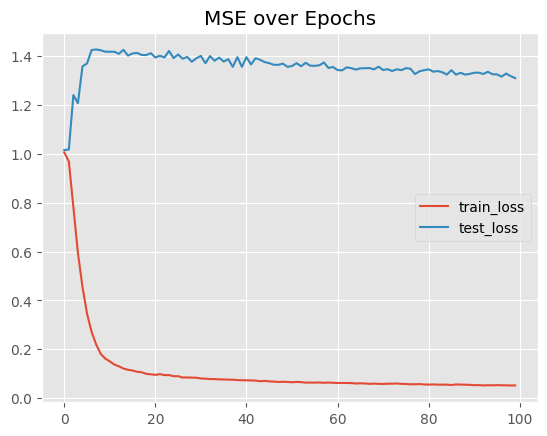

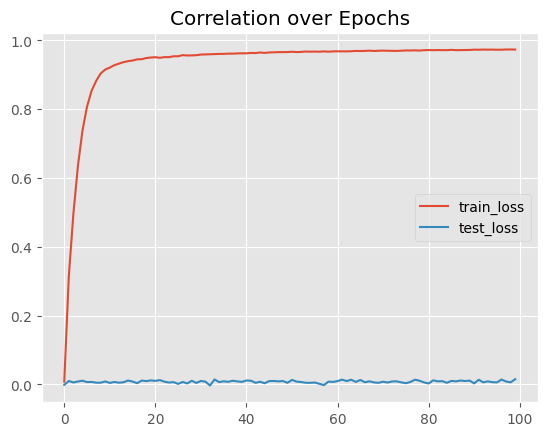

/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


0.07275349348569295 0.05628968173132811


In [36]:
z = dic_data['noise2']['d_all']
z.get_dataloader(n_rolling=10)

m = GlobalMLP(10, 10, 10, dropout=0.2).to(device)
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)

model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)
model_torch.fit(z.train, test=z.test, epochs=100, plot=True)

comp = benchmark_comparison.Comparator(models=[model_torch], model_names=['model_torch'])
        
out_train = comp.correl(z, mode="train", return_values=True).loc["model_torch", "optimal"]
out_test = comp.correl(z, mode="test", return_values=True).loc["model_torch", "optimal"]

print(out_train, out_test)

In [37]:
# Dataset types we want to evaluate
effects = ["d_cond", "d_shift", "d_cs", "d_cs_shift", "d_all"]

# Storage
records_train = []
records_test  = []

for noise_level in dic_data.keys():          # noise1, noise2, ...
    for effect in effects:                   # d_cond, d_shift, ...
        print(f"Running → {noise_level} | {effect}")

        z = dic_data[noise_level][effect]
        z.get_dataloader(n_rolling=10)       # creates z.train and z.test

        # Model
        model = GlobalMLP(10, 10, 10, dropout=0.2).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        wrapper = torch_benchmarks.TorchWrapper(model, optimizer=optimizer)

        # Train
        wrapper.fit(z.train, test=z.test, epochs=20, plot=False)

        # Compare
        comp = benchmark_comparison.Comparator(models=[wrapper], model_names=["mlp"])

        corr_train = comp.correl(z, mode="train", return_values=True)
        corr_test  = comp.correl(z, mode="test",  return_values=True)

        train_corr = corr_train.loc["mlp", "optimal"]
        test_corr  = corr_test.loc["mlp", "optimal"]

        # Save results
        records_train.append({
            "noise_level": noise_level,
            "effect": effect,
            "train_corr_optimal": train_corr
        })
        records_test.append({
            "noise_level": noise_level,
            "effect": effect,
            "test_corr_optimal": test_corr
        })

# ————————————————————————————————————————
# 3. Convert to nice DataFrames
# ————————————————————————————————————————
df_train = pd.DataFrame(records_train)
df_test  = pd.DataFrame(records_test)

# Pivot: rows = noise level, columns = effect type
train_pivot = df_train.pivot(index="noise_level", columns="effect", values="train_corr_optimal")
test_pivot  = df_test.pivot(index="noise_level", columns="effect", values="test_corr_optimal")

# Optional: nicer index with actual correlation values
new_index = [f"low={low:0.3f}, high={high:0.3f}" 
             for low, high in zip(list_low_corr, list_high_corr)]
train_pivot.index = new_index
test_pivot.index  = new_index

# Sort columns in logical order
col_order = ["d_cond", "d_shift", "d_cs", "d_cs_shift", "d_all"]
train_model1 = train_pivot[col_order]
test_model1  = test_pivot[col_order]

Running → noise1 | d_cond


100%|██████████| 20/20 [00:02<00:00,  9.33it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise1 | d_shift


100%|██████████| 20/20 [00:01<00:00, 10.06it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise1 | d_cs


100%|██████████| 20/20 [00:01<00:00, 10.53it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise1 | d_cs_shift


100%|██████████| 20/20 [00:02<00:00,  9.54it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise1 | d_all


100%|██████████| 20/20 [00:02<00:00,  9.93it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise2 | d_cond


100%|██████████| 20/20 [00:01<00:00, 10.22it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise2 | d_shift


100%|██████████| 20/20 [00:01<00:00, 10.45it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise2 | d_cs


100%|██████████| 20/20 [00:01<00:00, 10.63it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise2 | d_cs_shift


100%|██████████| 20/20 [00:01<00:00, 10.48it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise2 | d_all


100%|██████████| 20/20 [00:02<00:00,  9.91it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise3 | d_cond


100%|██████████| 20/20 [00:01<00:00, 10.59it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise3 | d_shift


100%|██████████| 20/20 [00:01<00:00, 10.62it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise3 | d_cs


100%|██████████| 20/20 [00:01<00:00, 10.49it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise3 | d_cs_shift


100%|██████████| 20/20 [00:01<00:00, 10.67it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise3 | d_all


100%|██████████| 20/20 [00:01<00:00, 10.64it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise4 | d_cond


100%|██████████| 20/20 [00:01<00:00, 10.62it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise4 | d_shift


100%|██████████| 20/20 [00:01<00:00, 10.06it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise4 | d_cs


100%|██████████| 20/20 [00:01<00:00, 10.59it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise4 | d_cs_shift


100%|██████████| 20/20 [00:01<00:00, 10.16it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise4 | d_all


100%|██████████| 20/20 [00:01<00:00, 10.39it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


In [38]:
print("\nTRAIN correlation with optimal predictor")
display(train_model1.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1).format(precision=3))

print("\nTEST correlation with optimal predictor")
display(test_model1.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1).format(precision=3))


TRAIN correlation with optimal predictor


effect,d_cond,d_shift,d_cs,d_cs_shift,d_all
"low=0.010, high=0.020",0.037,0.026,0.044,0.024,0.035
"low=0.025, high=0.050",0.083,0.093,0.088,0.093,0.072
"low=0.050, high=0.100",0.143,0.170,0.160,0.168,0.167
"low=0.100, high=0.200",0.305,0.352,0.289,0.297,0.314



TEST correlation with optimal predictor


effect,d_cond,d_shift,d_cs,d_cs_shift,d_all
"low=0.010, high=0.020",0.001,0.018,0.025,0.024,0.027
"low=0.025, high=0.050",0.004,0.103,0.099,0.078,0.058
"low=0.050, high=0.100",-0.010,0.168,0.170,0.183,0.146
"low=0.100, high=0.200",0.003,0.390,0.313,0.328,0.242


In [39]:
# We see this model fails to find d_cond..

In [40]:
# Lets vary the architecture and see if it gets better.

In [41]:
# Dataset types we want to evaluate
effects = ["d_cond", "d_shift", "d_cs", "d_cs_shift", "d_all"]

# Storage
records_train = []
records_test  = []

for noise_level in dic_data.keys():          # noise1, noise2, ...
    for effect in effects:                   # d_cond, d_shift, ...
        print(f"Running → {noise_level} | {effect}")

        z = dic_data[noise_level][effect]
        z.get_dataloader(n_rolling=10)       # creates z.train and z.test

        # Model
        model = GlobalMLP(10, 10, 10, num_layers=8, hidden_dim=256, dropout=0.2).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        wrapper = torch_benchmarks.TorchWrapper(model, optimizer=optimizer)

        # Train
        wrapper.fit(z.train, test=z.test, epochs=20, plot=False)

        # Compare
        comp = benchmark_comparison.Comparator(models=[wrapper], model_names=["mlp"])

        corr_train = comp.correl(z, mode="train", return_values=True)
        corr_test  = comp.correl(z, mode="test",  return_values=True)

        train_corr = corr_train.loc["mlp", "optimal"]
        test_corr  = corr_test.loc["mlp", "optimal"]

        # Save results
        records_train.append({
            "noise_level": noise_level,
            "effect": effect,
            "train_corr_optimal": train_corr
        })
        records_test.append({
            "noise_level": noise_level,
            "effect": effect,
            "test_corr_optimal": test_corr
        })

# ————————————————————————————————————————
# 3. Convert to nice DataFrames
# ————————————————————————————————————————
df_train = pd.DataFrame(records_train)
df_test  = pd.DataFrame(records_test)

# Pivot: rows = noise level, columns = effect type
train_pivot = df_train.pivot(index="noise_level", columns="effect", values="train_corr_optimal")
test_pivot  = df_test.pivot(index="noise_level", columns="effect", values="test_corr_optimal")

# Optional: nicer index with actual correlation values
new_index = [f"low={low:0.3f}, high={high:0.3f}" 
             for low, high in zip(list_low_corr, list_high_corr)]
train_pivot.index = new_index
test_pivot.index  = new_index

# Sort columns in logical order
col_order = ["d_cond", "d_shift", "d_cs", "d_cs_shift", "d_all"]
train_model1 = train_pivot[col_order]
test_model1  = test_pivot[col_order]

Running → noise1 | d_cond


100%|██████████| 20/20 [00:03<00:00,  6.37it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise1 | d_shift


100%|██████████| 20/20 [00:02<00:00,  8.88it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise1 | d_cs


100%|██████████| 20/20 [00:02<00:00,  8.28it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise1 | d_cs_shift


100%|██████████| 20/20 [00:02<00:00,  8.74it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise1 | d_all


100%|██████████| 20/20 [00:02<00:00,  8.86it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise2 | d_cond


100%|██████████| 20/20 [00:02<00:00,  9.02it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise2 | d_shift


100%|██████████| 20/20 [00:02<00:00,  9.11it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise2 | d_cs


100%|██████████| 20/20 [00:02<00:00,  9.11it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise2 | d_cs_shift


100%|██████████| 20/20 [00:02<00:00,  8.71it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise2 | d_all


100%|██████████| 20/20 [00:02<00:00,  8.99it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise3 | d_cond


100%|██████████| 20/20 [00:02<00:00,  9.11it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise3 | d_shift


100%|██████████| 20/20 [00:02<00:00,  9.17it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise3 | d_cs


100%|██████████| 20/20 [00:02<00:00,  9.08it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise3 | d_cs_shift


100%|██████████| 20/20 [00:02<00:00,  9.13it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise3 | d_all


100%|██████████| 20/20 [00:02<00:00,  8.64it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise4 | d_cond


100%|██████████| 20/20 [00:02<00:00,  9.12it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise4 | d_shift


100%|██████████| 20/20 [00:02<00:00,  9.20it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise4 | d_cs


100%|██████████| 20/20 [00:02<00:00,  9.13it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise4 | d_cs_shift


100%|██████████| 20/20 [00:02<00:00,  9.12it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise4 | d_all


100%|██████████| 20/20 [00:02<00:00,  9.11it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


In [42]:
print("\nTRAIN correlation with optimal predictor")
display(train_model1.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1).format(precision=3))

print("\nTEST correlation with optimal predictor")
display(test_model1.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1).format(precision=3))


TRAIN correlation with optimal predictor


effect,d_cond,d_shift,d_cs,d_cs_shift,d_all
"low=0.010, high=0.020",0.025,0.015,0.027,0.014,0.015
"low=0.025, high=0.050",0.068,0.071,0.059,0.064,0.050
"low=0.050, high=0.100",0.098,0.131,0.107,0.128,0.128
"low=0.100, high=0.200",0.194,0.247,0.236,0.201,0.231



TEST correlation with optimal predictor


effect,d_cond,d_shift,d_cs,d_cs_shift,d_all
"low=0.010, high=0.020",-0.014,0.008,0.033,0.015,0.009
"low=0.025, high=0.050",-0.003,0.065,0.047,0.063,0.035
"low=0.050, high=0.100",0.000,0.119,0.113,0.113,0.093
"low=0.100, high=0.200",0.003,0.208,0.247,0.207,0.162


In [45]:
# Let's move on to the smarter NN setup

# Testing NN2

In [50]:
# Next we run the same code as above on NN2

In [49]:

class PerSeriesThenGlobalMLP(nn.Module):
    def __init__(
        self,
        n_ts,          # N
        n_f,           # F
        n_rolling,     # T
        d_model=256,   # hidden size after per-series processing
        hidden_global=512,
        num_layers_local=3,
        num_layers_global=3,
        dropout=0.1,
    ):
        super().__init__()
        
        self.n_ts = n_ts
        self.d_model = d_model
        
        # --------------------------------------------------------------
        # 1. Local MLP: applied independently to each series
        #    Input per series: T × F  →  collapses to d_model
        # --------------------------------------------------------------
        local_layers = []
        dim = n_rolling * n_f
        for i in range(num_layers_local):
            local_layers.extend([
                nn.Linear(dim, d_model),
                nn.GELU(),
                nn.Dropout(dropout),
                nn.LayerNorm(d_model)
            ])
            dim = d_model
        # Final local projection
        local_layers.append(nn.Linear(dim, d_model))
        self.local_mlp = nn.Sequential(*local_layers)
        
        # --------------------------------------------------------------
        # 2. Global MLP: mixes information across the N series
        #    Input: N × d_model  →  N
        # --------------------------------------------------------------
        global_layers = []
        dim = n_ts * d_model
        for i in range(num_layers_global):
            global_layers.extend([
                nn.Linear(dim, hidden_global),
                nn.GELU(),
                nn.Dropout(dropout),
                nn.LayerNorm(hidden_global)
            ])
            dim = hidden_global
        global_layers.append(nn.Linear(hidden_global, n_ts))
        self.global_mlp = nn.Sequential(*global_layers)

    def forward(self, x):
        """
        x: (B, T, N, F)
        """
        B, T, N, F = x.shape
        
        # Reshape so each series becomes a separate "sample"
        x = x.permute(0, 2, 1, 3).reshape(B * N, T * F)   # (B*N, T*F)
        
        # Local processing: each series gets its own embedding
        local_emb = self.local_mlp(x)                     # (B*N, d_model)
        
        # Reshape back to have the series dimension explicit
        x_global = local_emb.view(B, N * self.d_model)    # (B, N*d_model)
        
        # Global mixing across series
        out = self.global_mlp(x_global)                   # (B, N)
        
        return out

100%|██████████| 100/100 [00:16<00:00,  6.25it/s]


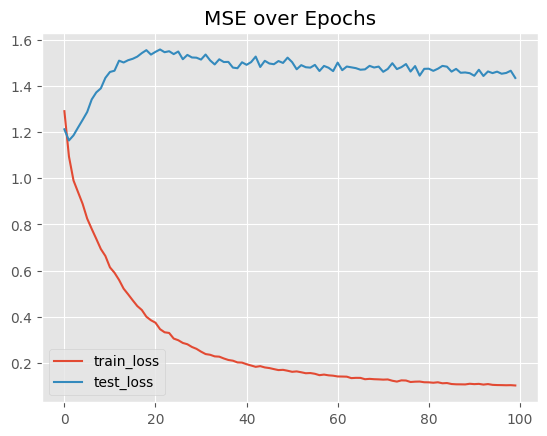

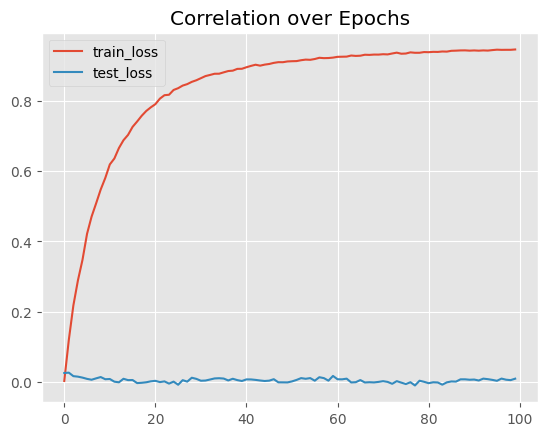

/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


0.07221273573098162 0.039407346435647465


In [51]:
z = dic_data['noise2']['d_all']
z.get_dataloader(n_rolling=10)

m = PerSeriesThenGlobalMLP(10, 10, 10, dropout=0.2).to(device)
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)

model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)
model_torch.fit(z.train, test=z.test, epochs=100, plot=True)

comp = benchmark_comparison.Comparator(models=[model_torch], model_names=['model_torch'])
        
out_train = comp.correl(z, mode="train", return_values=True).loc["model_torch", "optimal"]
out_test = comp.correl(z, mode="test", return_values=True).loc["model_torch", "optimal"]

print(out_train, out_test)

In [52]:
# Dataset types we want to evaluate
effects = ["d_cond", "d_shift", "d_cs", "d_cs_shift", "d_all"]

# Storage
records_train = []
records_test  = []

for noise_level in dic_data.keys():          # noise1, noise2, ...
    for effect in effects:                   # d_cond, d_shift, ...
        print(f"Running → {noise_level} | {effect}")

        z = dic_data[noise_level][effect]
        z.get_dataloader(n_rolling=10)       # creates z.train and z.test

        # Model
        model = PerSeriesThenGlobalMLP(10, 10, 10, dropout=0.2).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        wrapper = torch_benchmarks.TorchWrapper(model, optimizer=optimizer)

        # Train
        wrapper.fit(z.train, test=z.test, epochs=50, plot=False)

        # Compare
        comp = benchmark_comparison.Comparator(models=[wrapper], model_names=["mlp"])

        corr_train = comp.correl(z, mode="train", return_values=True)
        corr_test  = comp.correl(z, mode="test",  return_values=True)

        train_corr = corr_train.loc["mlp", "optimal"]
        test_corr  = corr_test.loc["mlp", "optimal"]

        # Save results
        records_train.append({
            "noise_level": noise_level,
            "effect": effect,
            "train_corr_optimal": train_corr
        })
        records_test.append({
            "noise_level": noise_level,
            "effect": effect,
            "test_corr_optimal": test_corr
        })

# ————————————————————————————————————————
# 3. Convert to nice DataFrames
# ————————————————————————————————————————
df_train = pd.DataFrame(records_train)
df_test  = pd.DataFrame(records_test)

# Pivot: rows = noise level, columns = effect type
train_pivot = df_train.pivot(index="noise_level", columns="effect", values="train_corr_optimal")
test_pivot  = df_test.pivot(index="noise_level", columns="effect", values="test_corr_optimal")

# Optional: nicer index with actual correlation values
new_index = [f"low={low:0.3f}, high={high:0.3f}" 
             for low, high in zip(list_low_corr, list_high_corr)]
train_pivot.index = new_index
test_pivot.index  = new_index

# Sort columns in logical order
col_order = ["d_cond", "d_shift", "d_cs", "d_cs_shift", "d_all"]
train_model2 = train_pivot[col_order]
test_model2  = test_pivot[col_order]

Running → noise1 | d_cond


100%|██████████| 50/50 [00:08<00:00,  5.78it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise1 | d_shift


100%|██████████| 50/50 [00:07<00:00,  6.61it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise1 | d_cs


100%|██████████| 50/50 [00:07<00:00,  6.60it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise1 | d_cs_shift


100%|██████████| 50/50 [00:07<00:00,  6.46it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise1 | d_all


100%|██████████| 50/50 [00:07<00:00,  6.64it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise2 | d_cond


100%|██████████| 50/50 [00:07<00:00,  6.55it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise2 | d_shift


100%|██████████| 50/50 [00:07<00:00,  6.42it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise2 | d_cs


100%|██████████| 50/50 [00:07<00:00,  6.57it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise2 | d_cs_shift


100%|██████████| 50/50 [00:07<00:00,  6.69it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise2 | d_all


100%|██████████| 50/50 [00:07<00:00,  6.63it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise3 | d_cond


100%|██████████| 50/50 [00:07<00:00,  6.62it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise3 | d_shift


100%|██████████| 50/50 [00:07<00:00,  6.67it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise3 | d_cs


100%|██████████| 50/50 [00:07<00:00,  6.63it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise3 | d_cs_shift


100%|██████████| 50/50 [00:07<00:00,  6.57it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise3 | d_all


100%|██████████| 50/50 [00:07<00:00,  6.61it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise4 | d_cond


100%|██████████| 50/50 [00:07<00:00,  6.77it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise4 | d_shift


100%|██████████| 50/50 [00:07<00:00,  6.42it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise4 | d_cs


100%|██████████| 50/50 [00:07<00:00,  6.61it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise4 | d_cs_shift


100%|██████████| 50/50 [00:07<00:00,  6.73it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise4 | d_all


100%|██████████| 50/50 [00:07<00:00,  6.60it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


In [53]:
print("\nTRAIN correlation with optimal predictor")
display(train_model2.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1).format(precision=3))

print("\nTEST correlation with optimal predictor")
display(test_model2.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1).format(precision=3))


TRAIN correlation with optimal predictor


effect,d_cond,d_shift,d_cs,d_cs_shift,d_all
"low=0.010, high=0.020",0.035,0.023,0.042,0.021,0.029
"low=0.025, high=0.050",0.085,0.085,0.082,0.090,0.074
"low=0.050, high=0.100",0.142,0.158,0.156,0.159,0.160
"low=0.100, high=0.200",0.306,0.330,0.272,0.282,0.302



TEST correlation with optimal predictor


effect,d_cond,d_shift,d_cs,d_cs_shift,d_all
"low=0.010, high=0.020",0.031,0.008,0.015,0.018,-0.004
"low=0.025, high=0.050",0.012,0.075,0.057,0.103,0.038
"low=0.050, high=0.100",-0.012,0.137,0.207,0.206,0.128
"low=0.100, high=0.200",0.013,0.479,0.409,0.414,0.277


In [55]:
## Still can't find the conditional effect. Need to test more options of this architecture.

# Testing the most basic TS transformer

In [10]:
# In this section we test the following transformer.

In [11]:
# Basic transformer model with TS attention.

class TransformerEncoderModel(nn.Module):
    def __init__(self, n_ts, n_f, n_rolling, d_model=128, nhead=8, num_layers=2, dropout=0.8):
        super().__init__()
        self.input_dim = n_ts * n_f
        self.d_model = d_model

        # Linear projection of (n_ts*n_f) features
        self.input_proj = nn.Linear(self.input_dim, d_model)

        # Positional encoding (learned or sinusoidal)
        self.pos_embedding = nn.Parameter(torch.randn(1, n_rolling, d_model))

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=4 * d_model,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # prediction
        self.decoder = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, n_ts)
        )

    def forward(self, x, mask=None):
        # x: (batch, n_rolling, n_ts, n_f)
        B, n_rolling, n_ts, n_f = x.shape

        # Flatten dimensions that are not lookback
        x = x.reshape(B, n_rolling, n_ts*n_f)
        x = self.input_proj(x) + self.pos_embedding[:, :n_rolling, :]

        # pass through Transformer encoder
        causal_mask = torch.triu(torch.ones(n_rolling, n_rolling, device=x.device), diagonal=1).bool()
        encoded = self.encoder(x, mask=causal_mask)  

        # last time step’s embedding for prediction
        out = self.decoder(encoded[:, -1, :])  # (B, N)
        return out

100%|██████████| 100/100 [00:24<00:00,  4.15it/s]


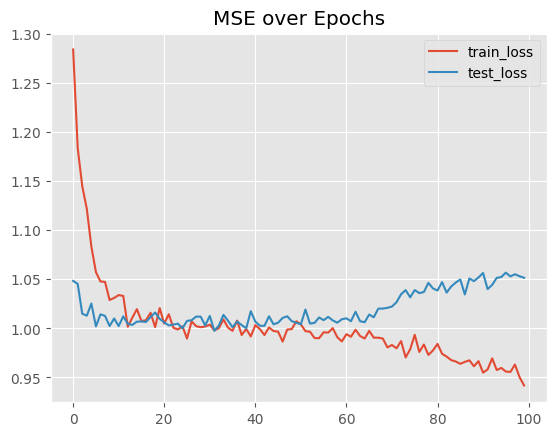

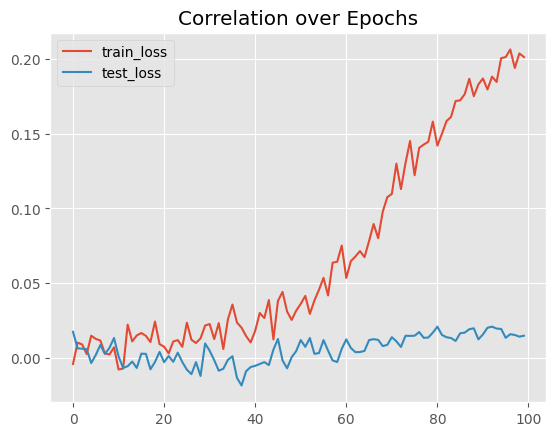

/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


0.2052242820189232 0.21169808009003213


In [12]:
z = dic_data['noise2']['d_all']
z.get_dataloader(n_rolling=10)

m = TransformerEncoderModel(10, 10, 10).to(device)
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)

model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)
model_torch.fit(z.train, test=z.test, epochs=100, plot=True)

comp = benchmark_comparison.Comparator(models=[model_torch], model_names=['model_torch'])
        
out_train = comp.correl(z, mode="train", return_values=True).loc["model_torch", "optimal"]
out_test = comp.correl(z, mode="test", return_values=True).loc["model_torch", "optimal"]

print(out_train, out_test)

In [13]:
# Dataset types we want to evaluate
effects = ["d_cond", "d_shift", "d_cs", "d_cs_shift", "d_all"]

# Storage
records_train = []
records_test  = []

for noise_level in dic_data.keys():          # noise1, noise2, ...
    for effect in effects:                   # d_cond, d_shift, ...
        print(f"Running → {noise_level} | {effect}")

        z = dic_data[noise_level][effect]
        z.get_dataloader(n_rolling=10)       # creates z.train and z.test

        # Model
        model = TransformerEncoderModel(10, 10, 10, dropout=0.8).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        wrapper = torch_benchmarks.TorchWrapper(model, optimizer=optimizer)

        # Train
        wrapper.fit(z.train, test=z.test, epochs=100, plot=False)

        # Compare
        comp = benchmark_comparison.Comparator(models=[wrapper], model_names=["mlp"])

        corr_train = comp.correl(z, mode="train", return_values=True)
        corr_test  = comp.correl(z, mode="test",  return_values=True)

        train_corr = corr_train.loc["mlp", "optimal"]
        test_corr  = corr_test.loc["mlp", "optimal"]

        # Save results
        records_train.append({
            "noise_level": noise_level,
            "effect": effect,
            "train_corr_optimal": train_corr
        })
        records_test.append({
            "noise_level": noise_level,
            "effect": effect,
            "test_corr_optimal": test_corr
        })

# ————————————————————————————————————————
# 3. Convert to nice DataFrames
# ————————————————————————————————————————
df_train = pd.DataFrame(records_train)
df_test  = pd.DataFrame(records_test)

# Pivot: rows = noise level, columns = effect type
train_pivot = df_train.pivot(index="noise_level", columns="effect", values="train_corr_optimal")
test_pivot  = df_test.pivot(index="noise_level", columns="effect", values="test_corr_optimal")

# Optional: nicer index with actual correlation values
new_index = [f"low={low:0.3f}, high={high:0.3f}" 
             for low, high in zip(list_low_corr, list_high_corr)]
train_pivot.index = new_index
test_pivot.index  = new_index

# Sort columns in logical order
col_order = ["d_cond", "d_shift", "d_cs", "d_cs_shift", "d_all"]
train_model3 = train_pivot[col_order]
test_model3  = test_pivot[col_order]

Running → noise1 | d_cond


100%|██████████| 100/100 [00:24<00:00,  4.15it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise1 | d_shift


100%|██████████| 100/100 [00:24<00:00,  4.13it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise1 | d_cs


100%|██████████| 100/100 [00:23<00:00,  4.21it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise1 | d_cs_shift


100%|██████████| 100/100 [00:23<00:00,  4.21it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise1 | d_all


100%|██████████| 100/100 [00:24<00:00,  4.10it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise2 | d_cond


100%|██████████| 100/100 [00:23<00:00,  4.20it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise2 | d_shift


100%|██████████| 100/100 [00:23<00:00,  4.20it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise2 | d_cs


100%|██████████| 100/100 [00:23<00:00,  4.24it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise2 | d_cs_shift


100%|██████████| 100/100 [00:23<00:00,  4.24it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise2 | d_all


100%|██████████| 100/100 [00:23<00:00,  4.31it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise3 | d_cond


100%|██████████| 100/100 [00:23<00:00,  4.26it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise3 | d_shift


100%|██████████| 100/100 [00:23<00:00,  4.31it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise3 | d_cs


100%|██████████| 100/100 [00:23<00:00,  4.27it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise3 | d_cs_shift


100%|██████████| 100/100 [00:23<00:00,  4.30it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise3 | d_all


100%|██████████| 100/100 [00:23<00:00,  4.25it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise4 | d_cond


100%|██████████| 100/100 [00:23<00:00,  4.25it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise4 | d_shift


100%|██████████| 100/100 [00:23<00:00,  4.26it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise4 | d_cs


100%|██████████| 100/100 [00:23<00:00,  4.29it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise4 | d_cs_shift


100%|██████████| 100/100 [00:23<00:00,  4.29it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise4 | d_all


100%|██████████| 100/100 [00:23<00:00,  4.18it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


In [14]:
print("\nTRAIN correlation with optimal predictor")
display(train_model3.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1).format(precision=3))

print("\nTEST correlation with optimal predictor")
display(test_model3.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1).format(precision=3))


TRAIN correlation with optimal predictor


effect,d_cond,d_shift,d_cs,d_cs_shift,d_all
"low=0.010, high=0.020",0.013,0.013,0.140,0.010,0.064
"low=0.025, high=0.050",0.018,0.019,0.390,0.014,0.184
"low=0.050, high=0.100",0.045,0.062,0.515,0.035,0.239
"low=0.100, high=0.200",0.060,0.139,0.644,0.317,0.427



TEST correlation with optimal predictor


effect,d_cond,d_shift,d_cs,d_cs_shift,d_all
"low=0.010, high=0.020",0.001,0.019,0.147,0.010,0.025
"low=0.025, high=0.050",0.001,0.012,0.376,-0.005,0.182
"low=0.050, high=0.100",0.008,0.039,0.510,0.016,0.198
"low=0.100, high=0.200",0.004,0.080,0.648,0.260,0.389


# CS transformer

In [62]:
# Need to make sure the model below is correct!

In [58]:
class DualAttentionTransformer(nn.Module):
    def __init__(
        self,
        n_ts,
        n_f,
        n_rolling,
        mask,
        d_model=128,
        nhead=8,
        num_temporal_layers=2,      
        num_series_layers=2,        
        dim_feedforward=512,
        dropout=0.1,
        sparsify=None
    ):
        super().__init__()
        self.d_model = d_model
        self.n_rolling = n_rolling
        self.n_ts = n_ts
        self.mask = mask
        self.sparsify = sparsify

        # ------------------------------------------------------------------
        # Input projection
        # ------------------------------------------------------------------
        self.input_proj = nn.Linear(n_f, d_model)

        # Learnable positional embeddings (broadcasted)
        self.pos_emb_time   = nn.Parameter(torch.randn(1, 1, d_model))      # time dimension
        self.pos_emb_series = nn.Parameter(torch.randn(1, 1, d_model))      # series dimension

        self.dropout = nn.Dropout(dropout)

        # ------------------------------------------------------------------
        # 1. Temporal-only blocks (applied on full (B, T, N, d) tensor)
        # ------------------------------------------------------------------
        self.temporal_blocks = nn.ModuleList()
        for _ in range(num_temporal_layers):
            encoder_layer = transformers.TransformerEncoderLayer(
                d_model, nhead, dim_feedforward, dropout,
            )
            encoder = transformers.TransformerEncoder(encoder_layer, num_layers=1)
            self.temporal_blocks.append(
                nn.ModuleDict({
                    'temporal': encoder,
                    'norm': nn.LayerNorm(d_model)
                })
            )

        # ------------------------------------------------------------------
        # 2. Series-only transformer (applied on (B, N, d) after picking last timestep)
        # ------------------------------------------------------------------
        self.series_blocks = nn.ModuleList()
        for _ in range(num_series_layers):
            encoder_layer = transformers.TransformerEncoderLayer(
                d_model, nhead, dim_feedforward, dropout,
            )
            encoder = transformers.TransformerEncoder(encoder_layer, num_layers=1)
            self.series_blocks.append(
                nn.ModuleDict({
                    'series': encoder,
                    'norm': nn.LayerNorm(d_model)
                })
            )

        # ------------------------------------------------------------------
        # Final prediction head
        # ------------------------------------------------------------------
        self.output_head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, 1)
        )

    # ----------------------------------------------------------------------
    # Temporal attention over time dimension (independent per series)
    # ----------------------------------------------------------------------
    def temporal_attention(self, x, block):
        """
        x : (B, T, N, D)
        Returns: (B, T, N, D)
        """
        B, T, N, D = x.shape
        # (B*N, T, D)
        x_flat = x.transpose(1, 2).contiguous().view(B * N, T, D)

        out = block['temporal'](
            x_flat,
            mask=self.mask,
            sparsify=self.sparsify
        )  # (B*N, T, D)

        out = out.view(B, N, T, D).transpose(1, 2)  # (B, T, N, D)
        return out

    # ----------------------------------------------------------------------
    # Series attention over the N dimension (after picking last timestep)
    # ----------------------------------------------------------------------
    def series_attention(self, x, block):
        """
        x : (B, N, D)   <-- already last timestep selected
        Returns: (B, N, D)
        """
        out = block['series'](x)   # standard batch_first transformer encoder
        return out

    # ----------------------------------------------------------------------
    def forward(self, x):
        """
        x : (B, T, N, n_f)   raw input
        Returns: (B, N)      predictions for each series
        """
        B, T, N, _ = x.shape

        # ------------------------------------------------------------------
        # Embed input + broadcast positional encodings
        # ------------------------------------------------------------------
        x = self.input_proj(x)                                   # (B, T, N, d_model)
        x = x + self.pos_emb_time + self.pos_emb_series
        x = self.dropout(x)

        # ------------------------------------------------------------------
        # 1. Temporal-only transformer layers (full spatio-temporal tensor)
        # ------------------------------------------------------------------
        for block in self.temporal_blocks:
            res = x
            x_t = self.temporal_attention(x, block)
            x = block['norm'](res + self.dropout(x_t))

        # ------------------------------------------------------------------
        # 2. Select last timestep → (B, N, d_model)
        # ------------------------------------------------------------------
        x = x[:, -1, :, :]        # (B, N, d_model)

        # ------------------------------------------------------------------
        # 3. Series-only transformer layers (attention across the N series)
        # ------------------------------------------------------------------
        for block in self.series_blocks:
            res = x
            x_s = self.series_attention(x, block)
            x = block['norm'](res + self.dropout(x_s))

        # ------------------------------------------------------------------
        # 4. Final prediction head
        # ------------------------------------------------------------------
        out = self.output_head(x)      # (B, N, 1)
        return out.squeeze(-1)         # (B, N)

In [31]:
def causal_mask(b, h, q_idx, kv_idx):
    return q_idx >= kv_idx

def build_attention_mask(mask_fn, seq_len, device="cpu"):
    q_idx = torch.arange(seq_len, device=device)
    kv_idx = torch.arange(seq_len, device=device)
    b = torch.zeros(1, device=device)
    h = torch.zeros(1, device=device)
    mask_bool = mask_fn(b, h, q_idx[:, None], kv_idx[None, :])  # (seq_len, seq_len)
    return mask_bool

mask = causal_mask
mask = build_attention_mask(mask, 10, device=device)
def custom_mask_mod(b, h, q_idx, kv_idx):
    return mask[q_idx, kv_idx]

In [32]:
device='mps'

100%|██████████| 60/60 [01:04<00:00,  1.07s/it]


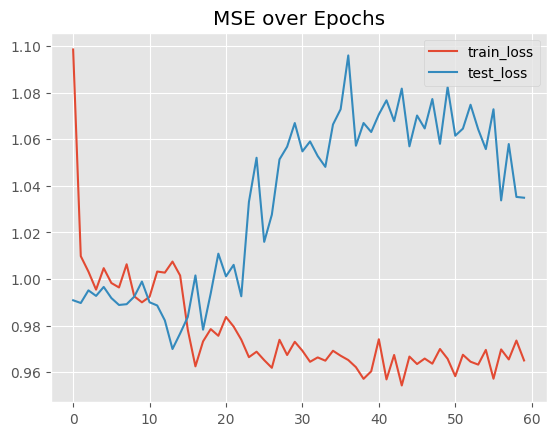

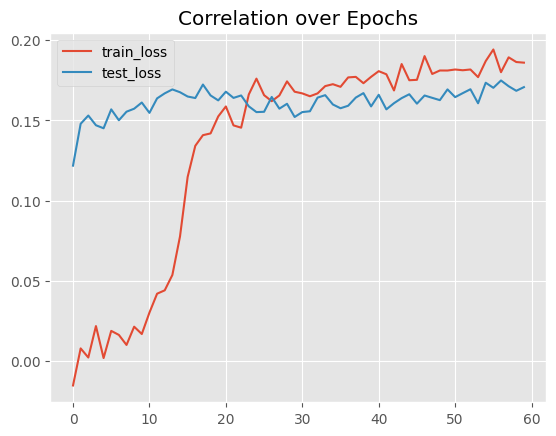

/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


0.2419869454472475 0.24765978609241948


In [34]:
z = dic_data['noise4']['d_all']
z.get_dataloader(n_rolling=10)

m = DualAttentionTransformer(10, 10, 10, mask=mask, d_model=128, dim_feedforward=512, dropout=0.5).to(device)
optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)
m = torch.compile(m, backend="eager")

model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer, device=device)
model_torch.fit(z.train, test=z.test, epochs=60, plot=True)

comp = benchmark_comparison.Comparator(models=[model_torch], model_names=['model_torch'])
        
out_train = comp.correl(z, mode="train", return_values=True).loc["model_torch", "optimal"]
out_test = comp.correl(z, mode="test", return_values=True).loc["model_torch", "optimal"]

print(out_train, out_test)

In [59]:
# Dataset types we want to evaluate
effects = ["d_cond", "d_shift", "d_cs", "d_cs_shift", "d_all"]

# Storage
records_train = []
records_test  = []

for noise_level in dic_data.keys():          # noise1, noise2, ...
    for effect in effects:                   # d_cond, d_shift, ...
        print(f"Running → {noise_level} | {effect}")

        z = dic_data[noise_level][effect]
        z.get_dataloader(n_rolling=10)       # creates z.train and z.test

        # Model
        m = DualAttentionTransformer(10, 10, 10, mask=mask, d_model=128, dim_feedforward=512, dropout=0.5).to(device)
        optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)
        m = torch.compile(m, backend="eager")
        wrapper = torch_benchmarks.TorchWrapper(m, optimizer=optimizer, device=device)

        # Train
        wrapper.fit(z.train, test=z.test, epochs=60, plot=False)

        # Compare
        comp = benchmark_comparison.Comparator(models=[wrapper], model_names=["mlp"])

        corr_train = comp.correl(z, mode="train", return_values=True)
        corr_test  = comp.correl(z, mode="test",  return_values=True)

        train_corr = corr_train.loc["mlp", "optimal"]
        test_corr  = corr_test.loc["mlp", "optimal"]

        # Save results
        records_train.append({
            "noise_level": noise_level,
            "effect": effect,
            "train_corr_optimal": train_corr
        })
        records_test.append({
            "noise_level": noise_level,
            "effect": effect,
            "test_corr_optimal": test_corr
        })

# ————————————————————————————————————————
# 3. Convert to nice DataFrames
# ————————————————————————————————————————
df_train = pd.DataFrame(records_train)
df_test  = pd.DataFrame(records_test)

# Pivot: rows = noise level, columns = effect type
train_pivot = df_train.pivot(index="noise_level", columns="effect", values="train_corr_optimal")
test_pivot  = df_test.pivot(index="noise_level", columns="effect", values="test_corr_optimal")

# Optional: nicer index with actual correlation values
new_index = [f"low={low:0.3f}, high={high:0.3f}" 
             for low, high in zip(list_low_corr, list_high_corr)]
train_pivot.index = new_index
test_pivot.index  = new_index

# Sort columns in logical order
col_order = ["d_cond", "d_shift", "d_cs", "d_cs_shift", "d_all"]
train_model_cs = train_pivot[col_order]
test_model_cs  = test_pivot[col_order]

Running → noise1 | d_cond


100%|██████████| 60/60 [01:06<00:00,  1.10s/it]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise1 | d_shift


100%|██████████| 60/60 [01:07<00:00,  1.13s/it]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise1 | d_cs


100%|██████████| 60/60 [01:07<00:00,  1.13s/it]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise1 | d_cs_shift


100%|██████████| 60/60 [01:06<00:00,  1.11s/it]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise1 | d_all


100%|██████████| 60/60 [01:05<00:00,  1.09s/it]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise2 | d_cond


100%|██████████| 60/60 [01:05<00:00,  1.09s/it]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise2 | d_shift


100%|██████████| 60/60 [01:04<00:00,  1.07s/it]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise2 | d_cs


100%|██████████| 60/60 [01:04<00:00,  1.07s/it]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise2 | d_cs_shift


100%|██████████| 60/60 [01:03<00:00,  1.07s/it]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise2 | d_all


100%|██████████| 60/60 [01:04<00:00,  1.07s/it]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise3 | d_cond


100%|██████████| 60/60 [01:03<00:00,  1.07s/it]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise3 | d_shift


100%|██████████| 60/60 [01:03<00:00,  1.07s/it]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise3 | d_cs


100%|██████████| 60/60 [01:04<00:00,  1.08s/it]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise3 | d_cs_shift


100%|██████████| 60/60 [01:04<00:00,  1.07s/it]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise3 | d_all


100%|██████████| 60/60 [01:04<00:00,  1.07s/it]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise4 | d_cond


100%|██████████| 60/60 [01:04<00:00,  1.07s/it]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise4 | d_shift


100%|██████████| 60/60 [01:04<00:00,  1.07s/it]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise4 | d_cs


100%|██████████| 60/60 [01:04<00:00,  1.07s/it]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise4 | d_cs_shift


100%|██████████| 60/60 [01:04<00:00,  1.07s/it]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise4 | d_all


100%|██████████| 60/60 [01:04<00:00,  1.07s/it]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


In [60]:
print("\nTRAIN correlation with optimal predictor")
display(train_model_cs.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1).format(precision=3))

print("\nTEST correlation with optimal predictor")
display(test_model_cs.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1).format(precision=3))


TRAIN correlation with optimal predictor


effect,d_cond,d_shift,d_cs,d_cs_shift,d_all
"low=0.010, high=0.020",0.004,-0.007,-0.001,-0.004,0.074
"low=0.025, high=0.050",0.008,0.003,0.044,0.007,0.250
"low=0.050, high=0.100",0.013,0.030,0.058,0.002,0.252
"low=0.100, high=0.200",0.005,0.049,0.140,0.004,0.245



TEST correlation with optimal predictor


effect,d_cond,d_shift,d_cs,d_cs_shift,d_all
"low=0.010, high=0.020",0.008,-0.011,0.005,-0.007,0.084
"low=0.025, high=0.050",0.007,0.013,0.022,-0.008,0.252
"low=0.050, high=0.100",-0.008,0.001,0.054,-0.007,0.264
"low=0.100, high=0.200",0.019,0.034,0.129,0.002,0.249


# TS MLP then CS Transformer

In [63]:
# Need to make sure the model below is correct!

In [52]:
class MLPSpatioTransformer(nn.Module):
    def __init__(
        self,
        n_ts,
        n_f,
        n_rolling,
        mask=None,           # kept for API compatibility, but unused
        d_model=128,
        nhead=8,
        mlp_layers=3,        # number of MLP layers per series
        num_series_layers=2, # transformer layers over the N dimension
        dim_feedforward=512,
        dropout=0.1,
        sparsify=None        # unused, kept for compatibility
    ):
        super().__init__()
        self.d_model = d_model
        self.n_rolling = n_rolling
        self.n_ts = n_ts
        self.mask = mask
        self.sparsify = sparsify

        # --------------------------------------------------------------
        # Input projection: (n_f) → d_model per timestep
        # --------------------------------------------------------------
        self.input_proj = nn.Linear(n_f, d_model)

        # Learnable positional embeddings (broadcasted)
        #self.pos_emb_time   = nn.Parameter(torch.randn(1, 1, d_model))
        self.pos_emb_series = nn.Parameter(torch.randn(1, 1, d_model))

        self.dropout = nn.Dropout(dropout)

        # --------------------------------------------------------------
        # 1. Per-series MLP: processes each (T, F) window independently
        # --------------------------------------------------------------
        input_dim = n_rolling * n_f
        mlp = []
        dim = input_dim

        for i in range(mlp_layers):
            mlp.extend([
                nn.Linear(dim, d_model),
                nn.GELU(),
                nn.LayerNorm(d_model),
                nn.Dropout(dropout)
            ])
            dim = d_model

        # Final projection to d_model
        mlp.append(nn.Linear(dim, d_model))
        self.per_series_mlp = nn.Sequential(*mlp)

        # --------------------------------------------------------------
        # 2. Series Transformer (after selecting last timestep)
        # --------------------------------------------------------------
        self.series_blocks = nn.ModuleList()
        for _ in range(num_series_layers):
            encoder_layer = transformers.TransformerEncoderLayer(
                d_model=d_model,
                nhead=nhead,
                dim_feedforward=dim_feedforward,
                dropout=dropout,
            )
            encoder = transformers.TransformerEncoder(encoder_layer, num_layers=1)
            self.series_blocks.append(
                nn.ModuleDict({
                    'series': encoder,
                    'norm': nn.LayerNorm(d_model)
                })
            )

        # --------------------------------------------------------------
        # Final prediction head
        # --------------------------------------------------------------
        self.output_head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, 1)
        )

    def forward(self, x):

        """
        x: (B, T, N, n_f)
        Returns: (B, N)
        """
        B, T, N, F = x.shape

        # --------------------------------------------------------------
        # Step 1: Apply per-series MLP over full time window
        # --------------------------------------------------------------
        # Reshape to (B*N, T*F) → treat each series independently
        x_flat = x.reshape(B * N, T * F)                    # (B*N, T*F)
        x_mlp = self.per_series_mlp(x_flat)
                        
        x = x_mlp.view(B, N, self.d_model)

        # Broadcast positional embeddings (now only one "time step")
        x = x + self.pos_emb_series
        x = self.dropout(x)
        
        # --------------------------------------------------------------
        # Step 3: Series Transformer — attention across N series
        # --------------------------------------------------------------
        for block in self.series_blocks:
            res = x
            x_s = block['series'](x)              # (B, N, d_model)
            x = block['norm'](res + self.dropout(x_s))

        # --------------------------------------------------------------
        # Step 4: Final prediction
        # --------------------------------------------------------------
        out = self.output_head(x)                  # (B, N, 1)
        return out.squeeze(-1)                          # (B, N)
    

        
      


In [53]:
device='mps'

100%|██████████| 60/60 [00:16<00:00,  3.63it/s]


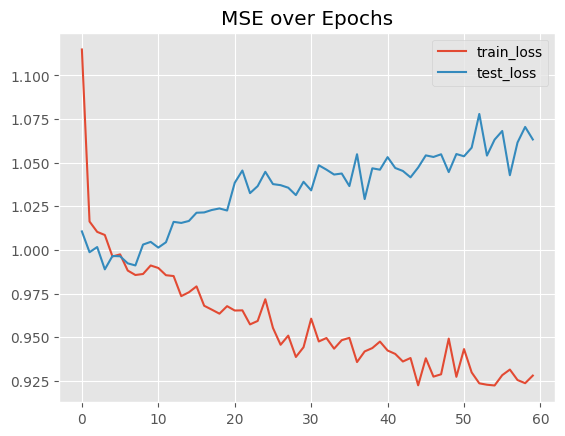

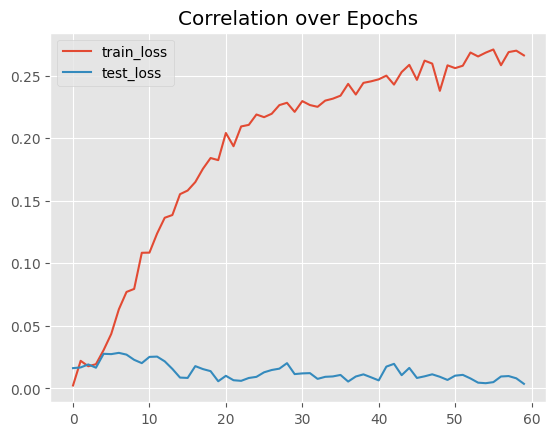

/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


0.10265642485628 0.028609142342439324


In [54]:
z = dic_data['noise4']['d_all']
z.get_dataloader(n_rolling=10)

m = MLPSpatioTransformer(10, 10, 10, d_model=128, dim_feedforward=512, dropout=0.2).to(device)
optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)
m = torch.compile(m, backend="eager")

model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer, device=device)
model_torch.fit(z.train, test=z.test, epochs=60, plot=True)

comp = benchmark_comparison.Comparator(models=[model_torch], model_names=['model_torch'])
        
out_train = comp.correl(z, mode="train", return_values=True).loc["model_torch", "optimal"]
out_test = comp.correl(z, mode="test", return_values=True).loc["model_torch", "optimal"]

print(out_train, out_test)

In [55]:
# Dataset types we want to evaluate
effects = ["d_cond", "d_shift", "d_cs", "d_cs_shift", "d_all"]

# Storage
records_train = []
records_test  = []

for noise_level in dic_data.keys():          # noise1, noise2, ...
    for effect in effects:                   # d_cond, d_shift, ...
        print(f"Running → {noise_level} | {effect}")

        z = dic_data[noise_level][effect]
        z.get_dataloader(n_rolling=10)       # creates z.train and z.test

        # Model
        m = MLPSpatioTransformer(10, 10, 10, d_model=128, dim_feedforward=512, dropout=0.2).to(device)
        optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)
        m = torch.compile(m, backend="eager")
        wrapper = torch_benchmarks.TorchWrapper(m, optimizer=optimizer, device=device)

        # Train
        wrapper.fit(z.train, test=z.test, epochs=60, plot=False)

        # Compare
        comp = benchmark_comparison.Comparator(models=[wrapper], model_names=["mlp"])

        corr_train = comp.correl(z, mode="train", return_values=True)
        corr_test  = comp.correl(z, mode="test",  return_values=True)

        train_corr = corr_train.loc["mlp", "optimal"]
        test_corr  = corr_test.loc["mlp", "optimal"]

        # Save results
        records_train.append({
            "noise_level": noise_level,
            "effect": effect,
            "train_corr_optimal": train_corr
        })
        records_test.append({
            "noise_level": noise_level,
            "effect": effect,
            "test_corr_optimal": test_corr
        })

# ————————————————————————————————————————
# 3. Convert to nice DataFrames
# ————————————————————————————————————————
df_train = pd.DataFrame(records_train)
df_test  = pd.DataFrame(records_test)

# Pivot: rows = noise level, columns = effect type
train_pivot = df_train.pivot(index="noise_level", columns="effect", values="train_corr_optimal")
test_pivot  = df_test.pivot(index="noise_level", columns="effect", values="test_corr_optimal")

# Optional: nicer index with actual correlation values
new_index = [f"low={low:0.3f}, high={high:0.3f}" 
             for low, high in zip(list_low_corr, list_high_corr)]
train_pivot.index = new_index
test_pivot.index  = new_index

# Sort columns in logical order
col_order = ["d_cond", "d_shift", "d_cs", "d_cs_shift", "d_all"]
train_model_mlpcs = train_pivot[col_order]
test_model_mlpcs  = test_pivot[col_order]

Running → noise1 | d_cond


100%|██████████| 60/60 [00:15<00:00,  3.77it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise1 | d_shift


100%|██████████| 60/60 [00:14<00:00,  4.03it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise1 | d_cs


100%|██████████| 60/60 [00:15<00:00,  3.97it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise1 | d_cs_shift


100%|██████████| 60/60 [00:14<00:00,  4.06it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise1 | d_all


100%|██████████| 60/60 [00:14<00:00,  4.15it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise2 | d_cond


100%|██████████| 60/60 [00:14<00:00,  4.02it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise2 | d_shift


100%|██████████| 60/60 [00:14<00:00,  4.05it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise2 | d_cs


100%|██████████| 60/60 [00:14<00:00,  4.11it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise2 | d_cs_shift


100%|██████████| 60/60 [00:14<00:00,  4.03it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise2 | d_all


100%|██████████| 60/60 [00:14<00:00,  4.10it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise3 | d_cond


100%|██████████| 60/60 [00:14<00:00,  4.10it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise3 | d_shift


100%|██████████| 60/60 [00:15<00:00,  3.98it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise3 | d_cs


100%|██████████| 60/60 [00:14<00:00,  4.03it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise3 | d_cs_shift


100%|██████████| 60/60 [00:14<00:00,  4.02it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise3 | d_all


100%|██████████| 60/60 [00:15<00:00,  3.90it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise4 | d_cond


100%|██████████| 60/60 [00:14<00:00,  4.05it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise4 | d_shift


100%|██████████| 60/60 [00:14<00:00,  4.13it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise4 | d_cs


100%|██████████| 60/60 [00:15<00:00,  3.99it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise4 | d_cs_shift


100%|██████████| 60/60 [00:14<00:00,  4.08it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise4 | d_all


100%|██████████| 60/60 [00:14<00:00,  4.06it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


In [56]:
print("\nTRAIN correlation with optimal predictor")
display(train_model_mlpcs.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1).format(precision=3))

print("\nTEST correlation with optimal predictor")
display(test_model_mlpcs.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1).format(precision=3))


TRAIN correlation with optimal predictor


effect,d_cond,d_shift,d_cs,d_cs_shift,d_all
"low=0.010, high=0.020",0.008,0.023,0.011,0.022,0.010
"low=0.025, high=0.050",0.023,0.018,0.044,0.025,0.024
"low=0.050, high=0.100",0.057,0.055,0.043,0.042,0.071
"low=0.100, high=0.200",0.079,0.101,0.075,0.090,0.100



TEST correlation with optimal predictor


effect,d_cond,d_shift,d_cs,d_cs_shift,d_all
"low=0.010, high=0.020",-0.009,-0.007,-0.021,0.004,0.014
"low=0.025, high=0.050",0.000,-0.007,-0.007,0.005,0.009
"low=0.050, high=0.100",-0.016,0.018,0.011,0.016,0.000
"low=0.100, high=0.200",-0.008,-0.003,0.019,0.008,0.015


In [57]:
# Ok something is wrong with the model...

# Alternating TS-CS transformer

In [10]:
# Here let's try out the following model.

In [11]:
class AlternatingDualAttentionTransformer(nn.Module):
    def __init__(
        self,
        n_ts,
        n_f,
        n_rolling,
        mask,
        d_model=128,
        nhead=8,
        num_layers=2,
        dim_feedforward=512,
        dropout=0.1,
        sparsify=None,
        roll_y=False
    ):
        super().__init__()
        self.d_model = d_model
        self.n_rolling = n_rolling
        self.n_ts = n_ts
        self.mask = mask
        self.sparsify = sparsify
        self.roll_y = roll_y

        self.input_proj = nn.Linear(n_f, d_model)

        # Broadcasted positional embeddings
        self.pos_emb_time   = nn.Parameter(torch.randn(1, 1, d_model))
        self.pos_emb_series = nn.Parameter(torch.randn(1, 1, d_model))

        self.dropout = nn.Dropout(dropout)

        self.blocks = nn.ModuleList()
        for _ in range(num_layers):
            temp = transformers.TransformerEncoder(
                transformers.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout),
                num_layers=1
            )
            # we only use the self_attn module from this one — series attention is custom
            series = transformers.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout)
            self.blocks.append(nn.ModuleDict({
                'temporal': temp,
                'series': series,
                'norm1': nn.LayerNorm(d_model),
                'norm2': nn.LayerNorm(d_model),
            }))

        self.output_head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, 1)
        )

    def series_attention(self, x, attn_layer):
        """
        x: (B, T, N, d)
        Applies attention independently for each (B, T) window over the N dimension.
        """
        B, T, N, D = x.shape

        x_flat = x.view(B*T, N, D)

        out = attn_layer.self_attn(x_flat, x_flat, x_flat,)

        out = out.view(B, T, N, D)
        return out
    
    def temporal_attention(self, x, attn_encoder):
        """
        x: (B, T, N, D)
        Applies temporal attention independently for each series (N dimension)
        using the stored TransformerEncoder.
        """
        B, T, N, D = x.shape
        x_flat = x.transpose(1, 2).contiguous().view(B*N, T, D)

        out = attn_encoder(x_flat, mask=self.mask, sparsify=self.sparsify)

        out = out.view(B, N, T, D).transpose(1, 2)
        return out

    def forward(self, x):
        B, T, N, _ = x.shape

        x = self.input_proj(x)

        # broadcast positional embeddings
        x = x + self.pos_emb_time + self.pos_emb_series

        for block in self.blocks:
            # temporal
            res = x
            x_t = self.temporal_attention(x, block['temporal'])
            x = block['norm1']((res + self.dropout(x_t)).contiguous())

            # series
            res = x
            x_s = self.series_attention(x, block['series'])
            x = block['norm2']((res + self.dropout(x_s)).contiguous())

        if self.roll_y == False:
            x = x[:, -1, :, :]
        
        return self.output_head(x).squeeze(-1)
                    

In [12]:
def causal_mask(b, h, q_idx, kv_idx):
    return q_idx >= kv_idx

def build_attention_mask(mask_fn, seq_len, device="cpu"):
    q_idx = torch.arange(seq_len, device=device)
    kv_idx = torch.arange(seq_len, device=device)
    b = torch.zeros(1, device=device)
    h = torch.zeros(1, device=device)
    mask_bool = mask_fn(b, h, q_idx[:, None], kv_idx[None, :])  # (seq_len, seq_len)
    return mask_bool

mask = causal_mask
mask = build_attention_mask(mask, 10, device=device)
def custom_mask_mod(b, h, q_idx, kv_idx):
    return mask[q_idx, kv_idx]

In [13]:
device='mps'

100%|██████████| 60/60 [01:32<00:00,  1.54s/it]


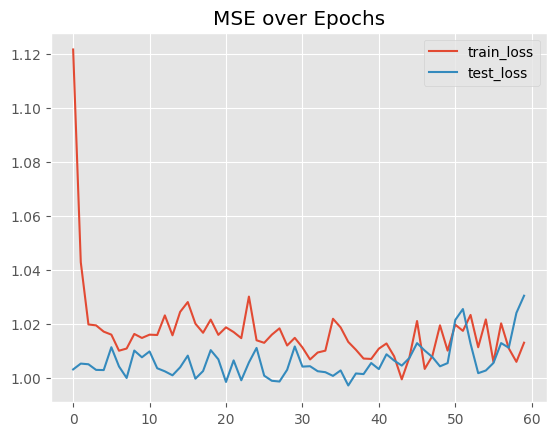

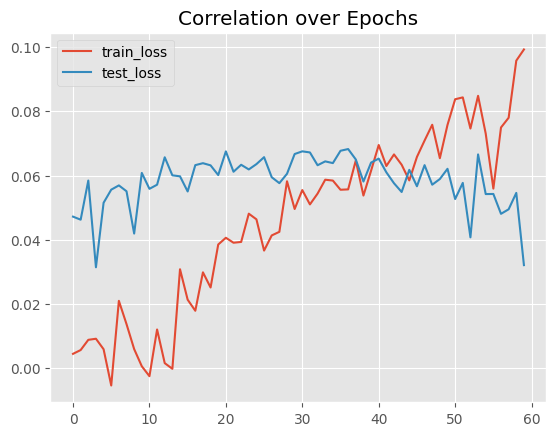

/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


0.23727171384279008 0.21943611964050802


In [14]:
z = dic_data['noise2']['d_all']
z.get_dataloader(n_rolling=10)

m = AlternatingDualAttentionTransformer(10, 10, 10, mask=mask, d_model=128, dim_feedforward=512, dropout=0.5, num_layers=2).to(device)
optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)
m = torch.compile(m, backend="eager")

model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer, device=device)
model_torch.fit(z.train, test=z.test, epochs=60, plot=True)

comp = benchmark_comparison.Comparator(models=[model_torch], model_names=['model_torch'])
        
out_train = comp.correl(z, mode="train", return_values=True).loc["model_torch", "optimal"]
out_test = comp.correl(z, mode="test", return_values=True).loc["model_torch", "optimal"]

print(out_train, out_test)

In [23]:
# Ok the above looks good. Let's run this on all the data.

In [ ]:
# Dataset types we want to evaluate
effects = ["d_cond", "d_shift", "d_cs", "d_cs_shift", "d_all"]

# Storage
records_train = []
records_test  = []

for noise_level in dic_data.keys():          # noise1, noise2, ...
    for effect in effects:                   # d_cond, d_shift, ...
        print(f"Running → {noise_level} | {effect}")

        z = dic_data[noise_level][effect]
        z.get_dataloader(n_rolling=10)       # creates z.train and z.test

        # Model
        m = AlternatingDualAttentionTransformer(10, 10, 10, mask=mask, d_model=128, dim_feedforward=512, dropout=0.5, num_layers=2).to(device)
        optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)
        m = torch.compile(m, backend="eager")
        wrapper = torch_benchmarks.TorchWrapper(m, optimizer=optimizer, device=device)

        # Train
        wrapper.fit(z.train, test=z.test, epochs=60, plot=False)

        # Compare
        comp = benchmark_comparison.Comparator(models=[wrapper], model_names=["mlp"])

        corr_train = comp.correl(z, mode="train", return_values=True)
        corr_test  = comp.correl(z, mode="test",  return_values=True)

        train_corr = corr_train.loc["mlp", "optimal"]
        test_corr  = corr_test.loc["mlp", "optimal"]

        # Save results
        records_train.append({
            "noise_level": noise_level,
            "effect": effect,
            "train_corr_optimal": train_corr
        })
        records_test.append({
            "noise_level": noise_level,
            "effect": effect,
            "test_corr_optimal": test_corr
        })

# ————————————————————————————————————————
# 3. Convert to nice DataFrames
# ————————————————————————————————————————
df_train = pd.DataFrame(records_train)
df_test  = pd.DataFrame(records_test)

# Pivot: rows = noise level, columns = effect type
train_pivot = df_train.pivot(index="noise_level", columns="effect", values="train_corr_optimal")
test_pivot  = df_test.pivot(index="noise_level", columns="effect", values="test_corr_optimal")

# Optional: nicer index with actual correlation values
new_index = [f"low={low:0.3f}, high={high:0.3f}" 
             for low, high in zip(list_low_corr, list_high_corr)]
train_pivot.index = new_index
test_pivot.index  = new_index

# Sort columns in logical order
col_order = ["d_cond", "d_shift", "d_cs", "d_cs_shift", "d_all"]
train_model4 = train_pivot[col_order]
test_model4  = test_pivot[col_order]

Running → noise1 | d_cond


100%|██████████| 60/60 [01:26<00:00,  1.45s/it]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise1 | d_shift


100%|██████████| 60/60 [01:26<00:00,  1.44s/it]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise1 | d_cs


100%|██████████| 60/60 [01:26<00:00,  1.43s/it]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise1 | d_cs_shift


100%|██████████| 60/60 [01:27<00:00,  1.46s/it]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise1 | d_all


100%|██████████| 60/60 [01:25<00:00,  1.43s/it]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise2 | d_cond


100%|██████████| 60/60 [01:25<00:00,  1.43s/it]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise2 | d_shift


100%|██████████| 60/60 [01:25<00:00,  1.42s/it]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise2 | d_cs


100%|██████████| 60/60 [01:25<00:00,  1.43s/it]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise2 | d_cs_shift


100%|██████████| 60/60 [01:25<00:00,  1.43s/it]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise2 | d_all


100%|██████████| 60/60 [01:25<00:00,  1.42s/it]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise3 | d_cond


100%|██████████| 60/60 [01:25<00:00,  1.43s/it]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise3 | d_shift


100%|██████████| 60/60 [07:48<00:00,  7.81s/it]  
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise3 | d_cs


100%|██████████| 60/60 [01:27<00:00,  1.45s/it]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise3 | d_cs_shift


100%|██████████| 60/60 [01:34<00:00,  1.57s/it]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise3 | d_all


100%|██████████| 60/60 [01:51<00:00,  1.85s/it]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise4 | d_cond


100%|██████████| 60/60 [01:25<00:00,  1.43s/it]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise4 | d_shift


100%|██████████| 60/60 [01:26<00:00,  1.43s/it]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise4 | d_cs


100%|██████████| 60/60 [01:28<00:00,  1.48s/it]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise4 | d_cs_shift


100%|██████████| 60/60 [01:28<00:00,  1.47s/it]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise4 | d_all


100%|██████████| 60/60 [01:25<00:00,  1.42s/it]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


In [25]:
print("\nTRAIN correlation with optimal predictor")
display(train_model4.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1).format(precision=3))

print("\nTEST correlation with optimal predictor")
display(test_model4.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1).format(precision=3))


TRAIN correlation with optimal predictor


effect,d_cond,d_shift,d_cs,d_cs_shift,d_all
"low=0.010, high=0.020",0.002,-0.002,-0.004,0.002,0.116
"low=0.025, high=0.050",0.023,0.008,0.083,-0.012,0.312
"low=0.050, high=0.100",0.070,0.047,0.082,0.000,0.281
"low=0.100, high=0.200",0.205,0.170,0.162,0.076,0.295



TEST correlation with optimal predictor


effect,d_cond,d_shift,d_cs,d_cs_shift,d_all
"low=0.010, high=0.020",0.014,0.016,0.023,-0.007,0.120
"low=0.025, high=0.050",0.037,-0.005,0.065,-0.020,0.304
"low=0.050, high=0.100",0.051,0.029,0.071,-0.016,0.297
"low=0.100, high=0.200",0.191,0.165,0.147,0.058,0.283


In [27]:
# These are not great results...

## Multi-dimensional y

In [14]:
## Let's implement the above model using multidimensional y

In [15]:
def causal_mask(b, h, q_idx, kv_idx):
    return q_idx >= kv_idx

def build_attention_mask(mask_fn, seq_len, device="cpu"):
    q_idx = torch.arange(seq_len, device=device)
    kv_idx = torch.arange(seq_len, device=device)
    b = torch.zeros(1, device=device)
    h = torch.zeros(1, device=device)
    mask_bool = mask_fn(b, h, q_idx[:, None], kv_idx[None, :])  # (seq_len, seq_len)
    return mask_bool

mask = causal_mask
mask = build_attention_mask(mask, 10, device=device)
def custom_mask_mod(b, h, q_idx, kv_idx):
    return mask[q_idx, kv_idx]

In [16]:
device='mps'

100%|██████████| 20/20 [00:33<00:00,  1.69s/it]


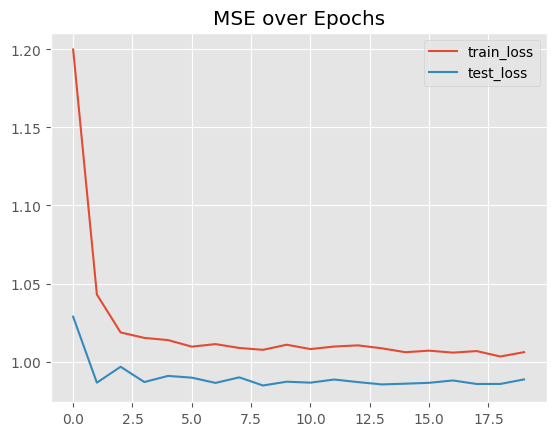

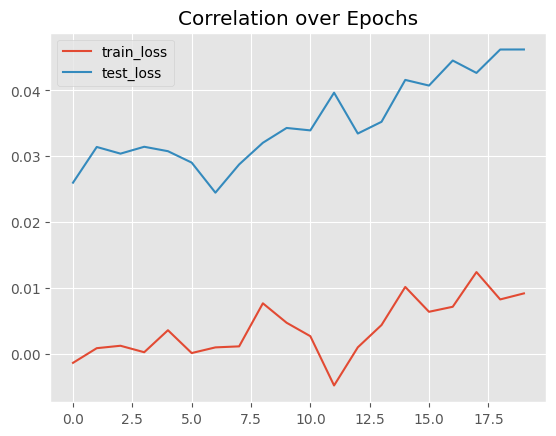

/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


0.20370388364139216 0.21699773721961552


In [17]:
z = dic_data['noise2']['d_all']
z.get_dataloader(n_rolling=10, roll_y=True)

m = AlternatingDualAttentionTransformer(10, 10, 10, mask=mask, d_model=128, dim_feedforward=512, dropout=0.5, num_layers=2, roll_y=True).to(device)
optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)
m = torch.compile(m, backend="eager")

model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer, device=device)
model_torch.fit(z.train, test=z.test, epochs=20, plot=True)

comp = benchmark_comparison.Comparator(models=[model_torch], model_names=['model_torch'])
        
out_train = comp.correl(z, mode="train", return_values=True).loc["model_torch", "optimal"]
out_test = comp.correl(z, mode="test", return_values=True).loc["model_torch", "optimal"]

print(out_train, out_test)

In [18]:
# Dataset types we want to evaluate
effects = ["d_cond", "d_shift", "d_cs", "d_cs_shift", "d_all"]

# Storage
records_train = []
records_test  = []

for noise_level in dic_data.keys():          # noise1, noise2, ...
    for effect in effects:                   # d_cond, d_shift, ...
        print(f"Running → {noise_level} | {effect}")

        z = dic_data[noise_level][effect]
        z.get_dataloader(n_rolling=10, roll_y=True)       # creates z.train and z.test

        # Model
        m = AlternatingDualAttentionTransformer(10, 10, 10, mask=mask, d_model=128, dim_feedforward=512, dropout=0.5, num_layers=2, roll_y=True).to(device)
        optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)
        m = torch.compile(m, backend="eager")
        wrapper = torch_benchmarks.TorchWrapper(m, optimizer=optimizer, device=device)

        # Train
        wrapper.fit(z.train, test=z.test, epochs=20, plot=False)

        # Compare
        comp = benchmark_comparison.Comparator(models=[wrapper], model_names=["mlp"])

        corr_train = comp.correl(z, mode="train", return_values=True)
        corr_test  = comp.correl(z, mode="test",  return_values=True)

        train_corr = corr_train.loc["mlp", "optimal"]
        test_corr  = corr_test.loc["mlp", "optimal"]

        # Save results
        records_train.append({
            "noise_level": noise_level,
            "effect": effect,
            "train_corr_optimal": train_corr
        })
        records_test.append({
            "noise_level": noise_level,
            "effect": effect,
            "test_corr_optimal": test_corr
        })

# ————————————————————————————————————————
# 3. Convert to nice DataFrames
# ————————————————————————————————————————
df_train = pd.DataFrame(records_train)
df_test  = pd.DataFrame(records_test)

# Pivot: rows = noise level, columns = effect type
train_pivot = df_train.pivot(index="noise_level", columns="effect", values="train_corr_optimal")
test_pivot  = df_test.pivot(index="noise_level", columns="effect", values="test_corr_optimal")

# Optional: nicer index with actual correlation values
new_index = [f"low={low:0.3f}, high={high:0.3f}" 
             for low, high in zip(list_low_corr, list_high_corr)]
train_pivot.index = new_index
test_pivot.index  = new_index

# Sort columns in logical order
col_order = ["d_cond", "d_shift", "d_cs", "d_cs_shift", "d_all"]
train_model4_multiy = train_pivot[col_order]
test_model4_multiy  = test_pivot[col_order]

Running → noise1 | d_cond


100%|██████████| 20/20 [00:29<00:00,  1.47s/it]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise1 | d_shift


100%|██████████| 20/20 [00:28<00:00,  1.45s/it]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise1 | d_cs


100%|██████████| 20/20 [00:29<00:00,  1.46s/it]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise1 | d_cs_shift


100%|██████████| 20/20 [00:29<00:00,  1.47s/it]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise1 | d_all


100%|██████████| 20/20 [00:29<00:00,  1.49s/it]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise2 | d_cond


100%|██████████| 20/20 [00:30<00:00,  1.52s/it]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise2 | d_shift


100%|██████████| 20/20 [00:29<00:00,  1.50s/it]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise2 | d_cs


100%|██████████| 20/20 [00:29<00:00,  1.46s/it]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise2 | d_cs_shift


100%|██████████| 20/20 [00:29<00:00,  1.48s/it]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise2 | d_all


100%|██████████| 20/20 [00:29<00:00,  1.49s/it]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise3 | d_cond


100%|██████████| 20/20 [00:29<00:00,  1.48s/it]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise3 | d_shift


100%|██████████| 20/20 [00:29<00:00,  1.45s/it]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise3 | d_cs


100%|██████████| 20/20 [00:29<00:00,  1.46s/it]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise3 | d_cs_shift


100%|██████████| 20/20 [00:29<00:00,  1.49s/it]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise3 | d_all


100%|██████████| 20/20 [00:29<00:00,  1.48s/it]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise4 | d_cond


100%|██████████| 20/20 [00:29<00:00,  1.46s/it]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise4 | d_shift


100%|██████████| 20/20 [00:29<00:00,  1.46s/it]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise4 | d_cs


100%|██████████| 20/20 [00:29<00:00,  1.46s/it]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise4 | d_cs_shift


100%|██████████| 20/20 [00:29<00:00,  1.48s/it]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Running → noise4 | d_all


100%|██████████| 20/20 [00:29<00:00,  1.46s/it]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


In [19]:
print("\nTRAIN correlation with optimal predictor")
display(train_model4_multiy.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1).format(precision=3))

print("\nTEST correlation with optimal predictor")
display(test_model4_multiy.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1).format(precision=3))


TRAIN correlation with optimal predictor


effect,d_cond,d_shift,d_cs,d_cs_shift,d_all
"low=0.010, high=0.020",0.010,0.007,0.012,-0.001,0.144
"low=0.025, high=0.050",0.024,0.008,0.036,0.019,0.209
"low=0.050, high=0.100",0.109,0.028,0.088,0.006,0.303
"low=0.100, high=0.200",0.615,0.275,0.157,0.034,0.518



TEST correlation with optimal predictor


effect,d_cond,d_shift,d_cs,d_cs_shift,d_all
"low=0.010, high=0.020",-0.001,0.005,-0.000,-0.013,0.141
"low=0.025, high=0.050",0.020,0.003,0.040,-0.009,0.223
"low=0.050, high=0.100",0.102,0.008,0.087,-0.000,0.309
"low=0.100, high=0.200",0.594,0.258,0.167,0.012,0.522


In [20]:
# This trains much faster and the results are a bit better than before.

## More tests by hand

In [14]:
# Let's do more tests by hand where we modify the architecture of the model to see if we can improve on the table above.

In [15]:
def causal_mask(b, h, q_idx, kv_idx):
    return q_idx >= kv_idx

def build_attention_mask(mask_fn, seq_len, device="cpu"):
    q_idx = torch.arange(seq_len, device=device)
    kv_idx = torch.arange(seq_len, device=device)
    b = torch.zeros(1, device=device)
    h = torch.zeros(1, device=device)
    mask_bool = mask_fn(b, h, q_idx[:, None], kv_idx[None, :])  # (seq_len, seq_len)
    return mask_bool

mask = causal_mask
mask = build_attention_mask(mask, 10, device=device)
def custom_mask_mod(b, h, q_idx, kv_idx):
    return mask[q_idx, kv_idx]

In [60]:
# Function used to make the attention matrix sparse

def keep_topk_per_row(x, k=2):
    vals, idx = torch.topk(x, k=k, dim=-1, largest=True)
    out = torch.zeros_like(x)
    out.scatter_(-1, idx, 1)
    return out

In [61]:
device='mps'

From the test by hand done so far:
- nhead = 4 seems good, actually maybe 8 or 16 is better?
- num_layers = 2 seems good

In [62]:
dic_data['noise1'].keys()

dict_keys(['d_cond', 'd_shift', 'd_cs', 'd_cs_shift', 'd_all'])

100%|██████████| 60/60 [00:53<00:00,  1.13it/s]


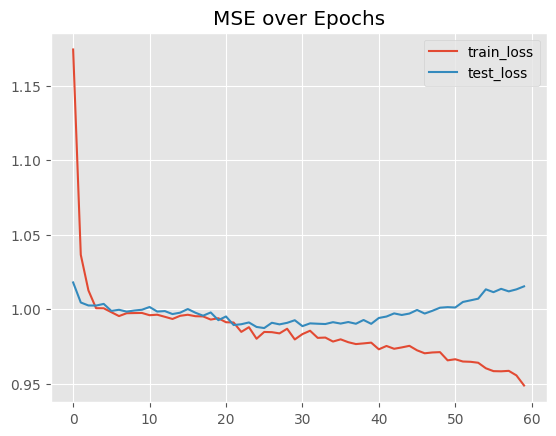

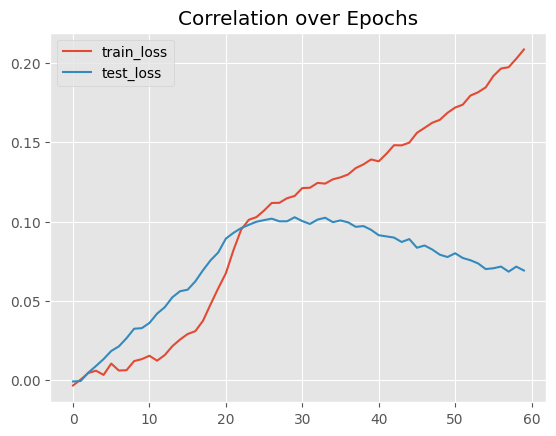

/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


0.07608507542087828 0.030521626117395652


In [68]:
z = dic_data['noise4']['d_cs_shift']
z.get_dataloader(n_rolling=10, roll_y=True)

m = AlternatingDualAttentionTransformer(10, 10, 10, mask=mask, d_model=64, dim_feedforward=64*4, dropout=0.2,
                                         nhead=8, num_layers=2, roll_y=True).to(device)
optimizer = torch.optim.AdamW(m.parameters(), lr=0.001, weight_decay=1)
m = torch.compile(m, backend="eager")

model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer, device=device)
model_torch.fit(z.train, test=z.test, epochs=60, plot=True)

comp = benchmark_comparison.Comparator(models=[model_torch], model_names=['model_torch'])
        
out_train = comp.correl(z, mode="train", return_values=True).loc["model_torch", "optimal"]
out_test = comp.correl(z, mode="test", return_values=True).loc["model_torch", "optimal"]
 
print(out_train, out_test)

### Long training run

100%|██████████| 1000/1000 [12:32<00:00,  1.33it/s]


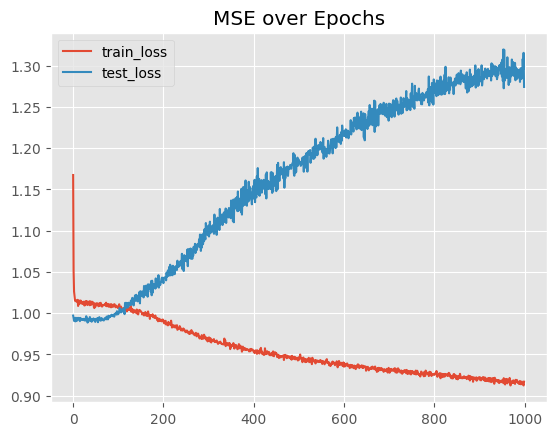

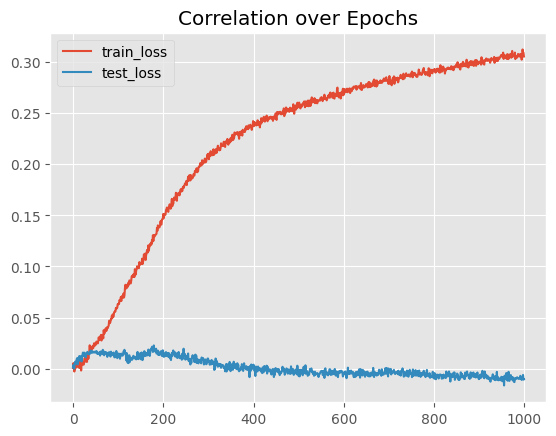

/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


0.07680391780377914 0.068993542324948


In [16]:
z = dic_data['noise1']['d_all']
z.get_dataloader(n_rolling=10, roll_y=True)

m = AlternatingDualAttentionTransformer(10, 10, 10, mask=mask, d_model=64, dim_feedforward=64*4, dropout=0.5, nhead=4, num_layers=2, roll_y=True).to(device)
optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)
m = torch.compile(m, backend="eager")

model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer, device=device)
model_torch.fit(z.train, test=z.test, epochs=1000, plot=True)

comp = benchmark_comparison.Comparator(models=[model_torch], model_names=['model_torch'])
        
out_train = comp.correl(z, mode="train", return_values=True).loc["model_torch", "optimal"]
out_test = comp.correl(z, mode="test", return_values=True).loc["model_torch", "optimal"]

print(out_train, out_test)

In [17]:
# Tried a very long training run above, not sure this what we want to do..

### Loop over d_model

In [27]:
# Lets write a quick look over d_model to see what is best.

In [29]:
list_d_model = [16, 32, 64, 128, 256]
list_dff = [4*x for x in list_d_model]

100%|██████████| 60/60 [00:25<00:00,  2.33it/s]


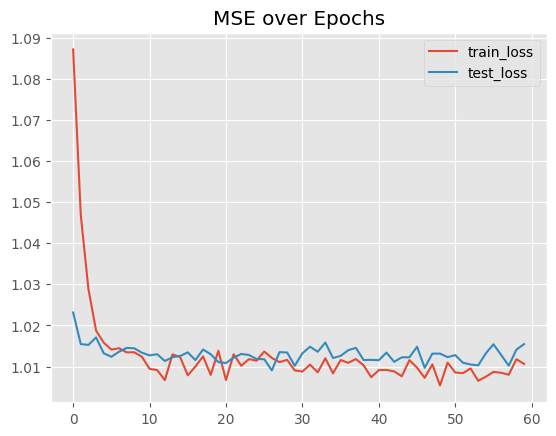

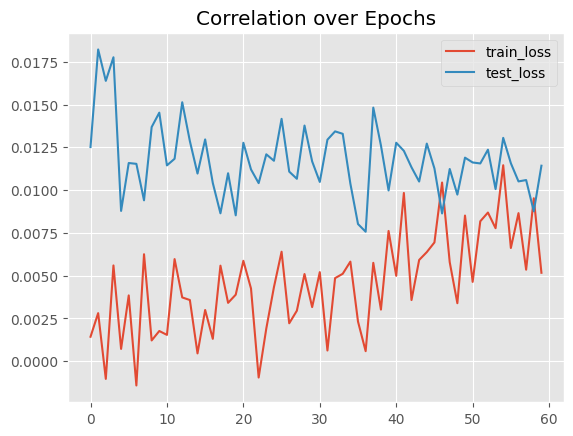

/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)



Results for d_model = 16
0.17064981432483758 0.1907907004014954


100%|██████████| 60/60 [00:32<00:00,  1.87it/s]


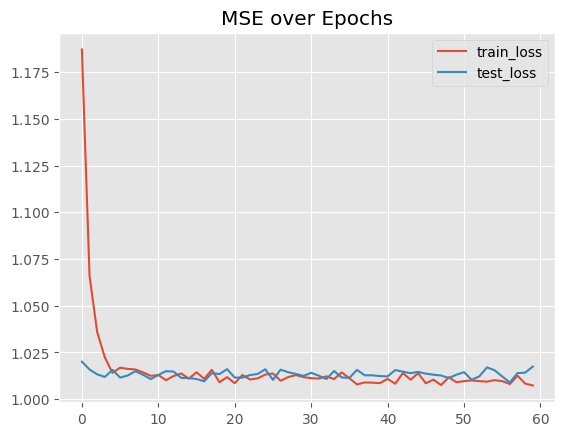

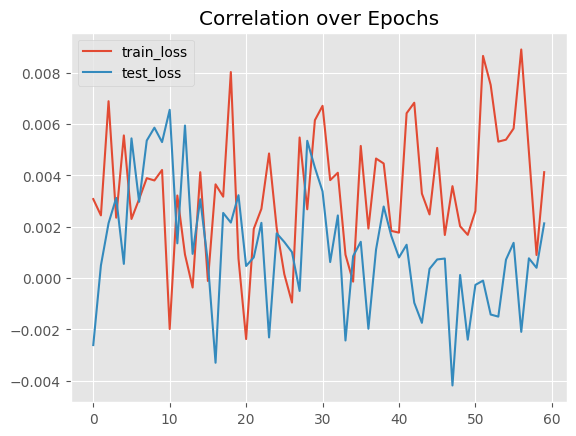

/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)



Results for d_model = 32
0.03375215183563178 0.049843473920918153


100%|██████████| 60/60 [00:44<00:00,  1.35it/s]


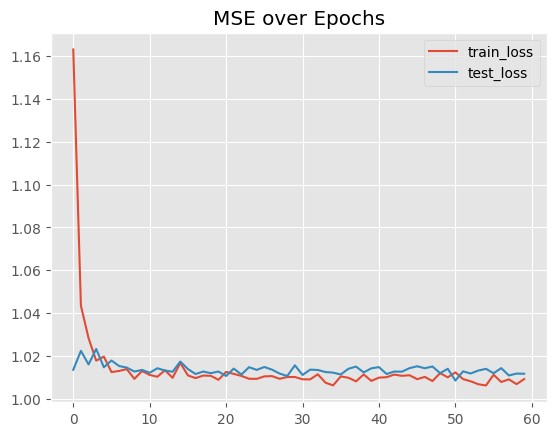

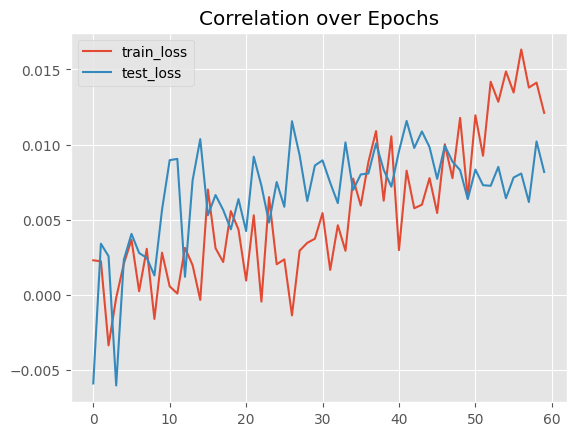

/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)



Results for d_model = 64
0.15167176396342943 0.17577702605077677


100%|██████████| 60/60 [01:24<00:00,  1.41s/it]


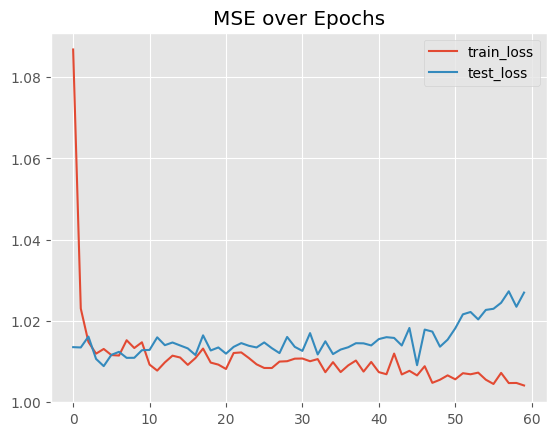

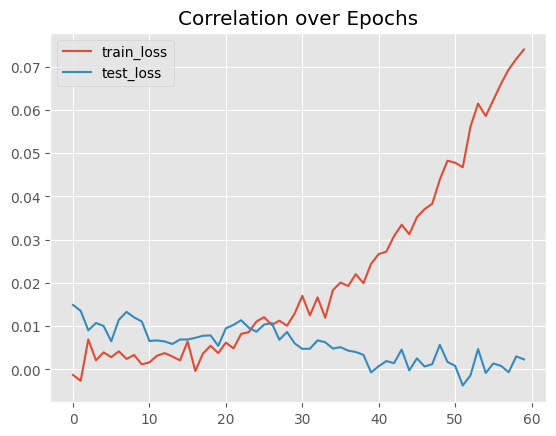

/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)



Results for d_model = 128
0.08716626223280416 0.09070417564864948


100%|██████████| 60/60 [03:06<00:00,  3.11s/it]


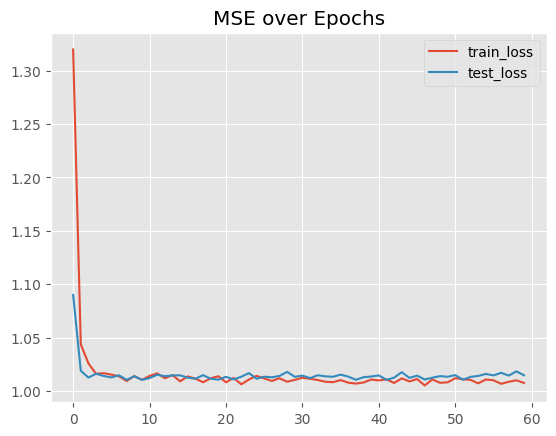

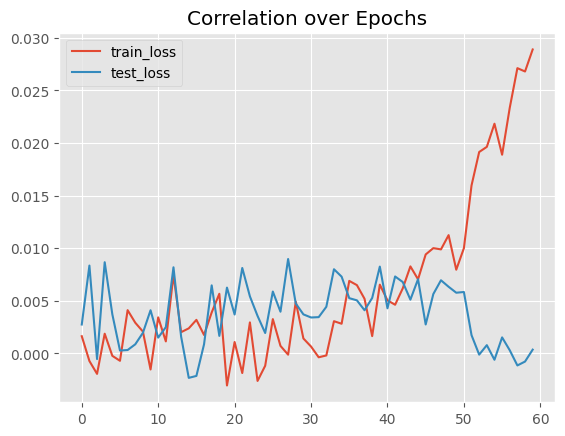

/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)



Results for d_model = 256
0.14149522789683613 0.1574496703114966


In [31]:
for i in range(len(list_d_model)):

    z = dic_data['noise1']['d_all']
    z.get_dataloader(n_rolling=10, roll_y=True)

    m = AlternatingDualAttentionTransformer(10, 10, 10, mask=mask, d_model=list_d_model[i], dim_feedforward=list_dff[i], dropout=0.5, nhead=4, num_layers=2, roll_y=True).to(device)
    optimizer = torch.optim.AdamW(m.parameters(), lr=0.001)
    m = torch.compile(m, backend="eager")

    model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer, device=device)
    model_torch.fit(z.train, test=z.test, epochs=60, plot=True)

    comp = benchmark_comparison.Comparator(models=[model_torch], model_names=['model_torch'])
            
    out_train = comp.correl(z, mode="train", return_values=True).loc["model_torch", "optimal"]
    out_test = comp.correl(z, mode="test", return_values=True).loc["model_torch", "optimal"]
    print("\nResults for d_model =", list_d_model[i])
    print(out_train, out_test)

In [32]:
# Above the result seem a bit random... not clear what to take away from this.

### Loop over weight_decay

In [36]:
dic_data['noise1'].keys()

dict_keys(['d_cond', 'd_shift', 'd_cs', 'd_cs_shift', 'd_all'])

In [38]:
list_weight_decay = [0, 0.001, 0.01, 0.1, 0.2, 0.5, 1, 10]

100%|██████████| 40/40 [00:36<00:00,  1.11it/s]


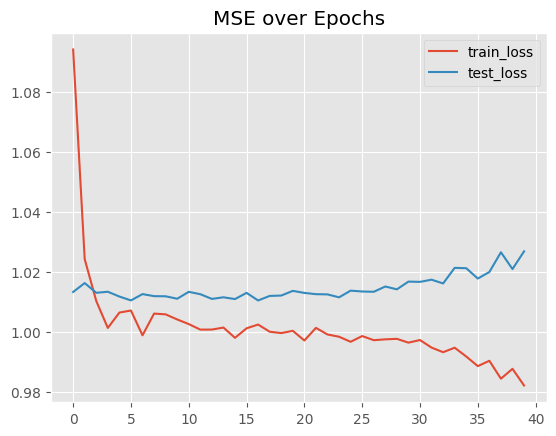

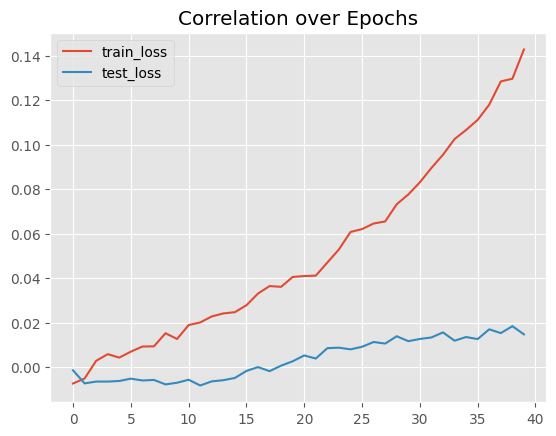

/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Results for weight decay equal to: 0
0.16412750690735095 0.17031500791778392


100%|██████████| 40/40 [00:35<00:00,  1.13it/s]


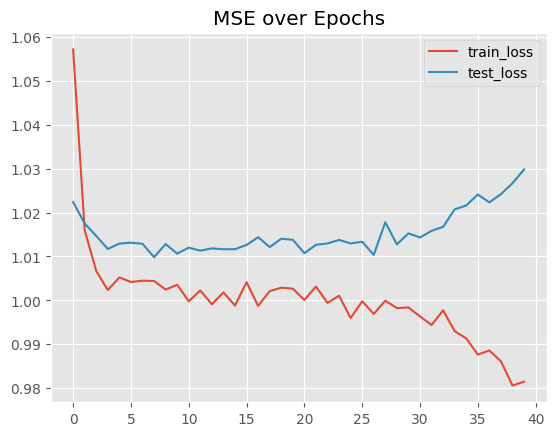

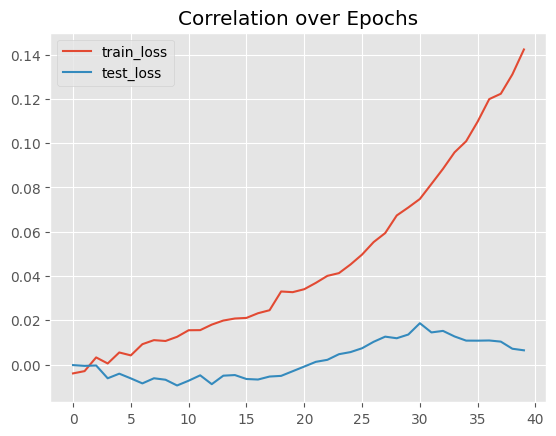

/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Results for weight decay equal to: 0.001
0.14435448188136565 0.15989135150252662


100%|██████████| 40/40 [00:35<00:00,  1.14it/s]


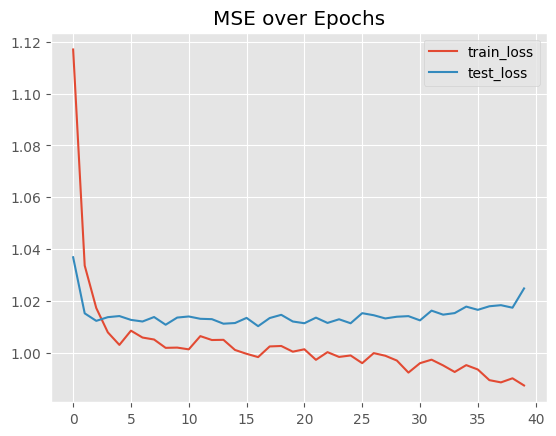

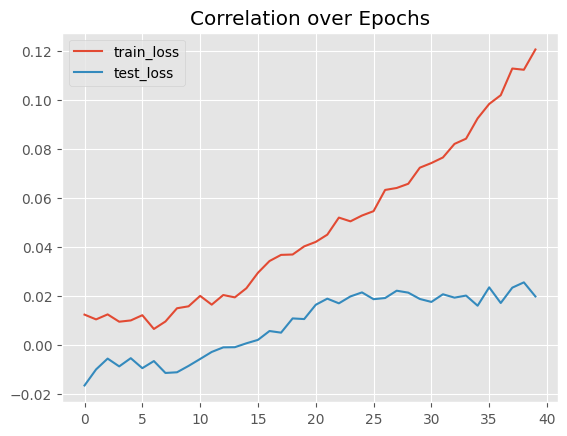

/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Results for weight decay equal to: 0.01
0.19731536144750295 0.19660734195709126


100%|██████████| 40/40 [00:35<00:00,  1.13it/s]


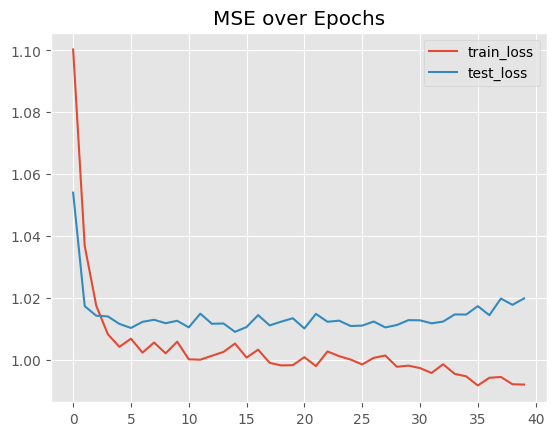

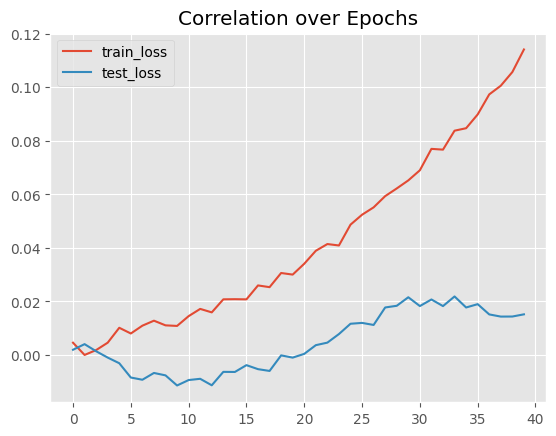

/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Results for weight decay equal to: 0.1
0.23028023610306272 0.22562046522162213


100%|██████████| 40/40 [00:35<00:00,  1.13it/s]


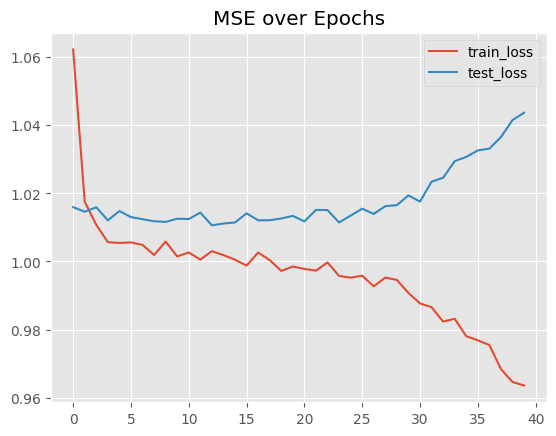

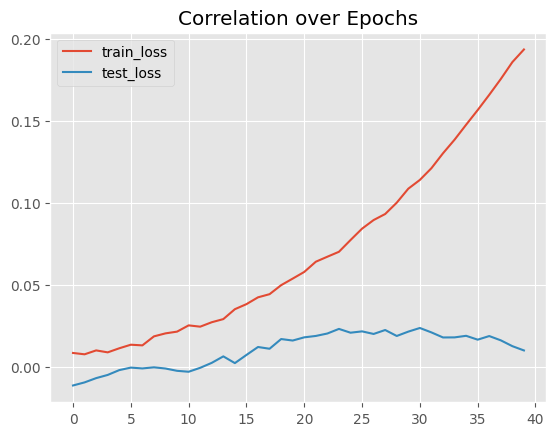

/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Results for weight decay equal to: 0.2
0.14100929463614306 0.14066820975803174


100%|██████████| 40/40 [00:35<00:00,  1.14it/s]


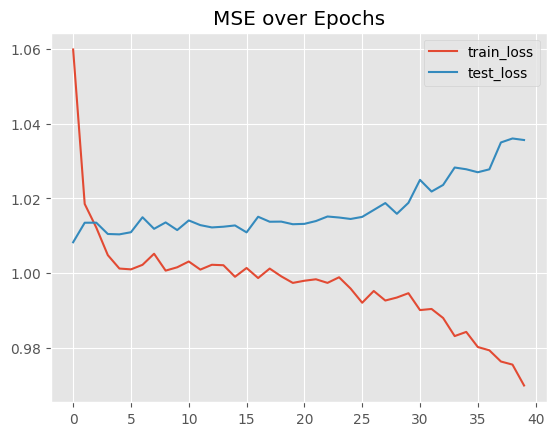

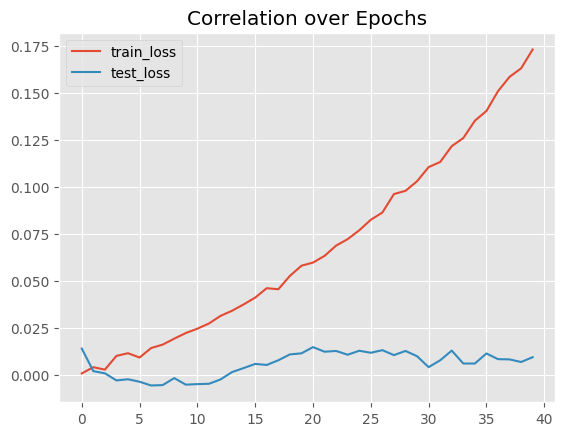

/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Results for weight decay equal to: 0.5
0.13994316219225958 0.13078763131599033


100%|██████████| 40/40 [00:35<00:00,  1.14it/s]


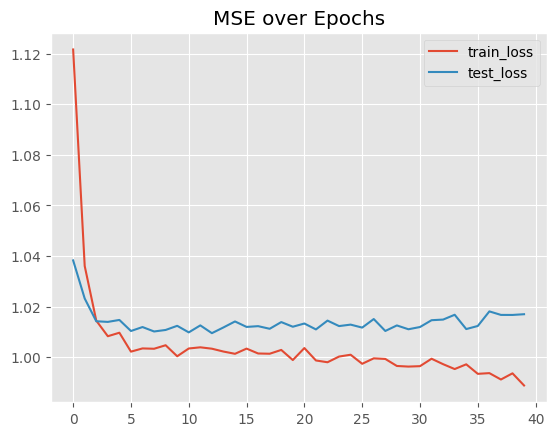

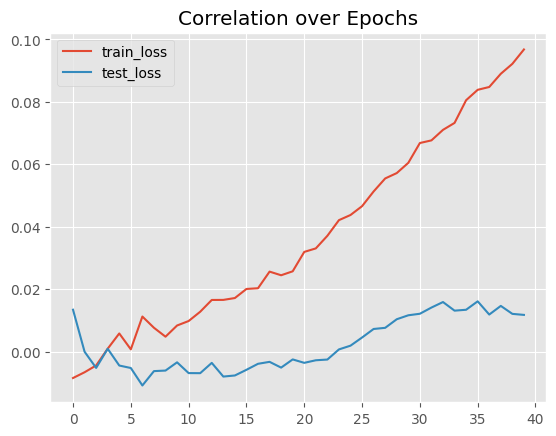

/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Results for weight decay equal to: 1
0.22381878936405405 0.23792502515971825


100%|██████████| 40/40 [00:35<00:00,  1.13it/s]


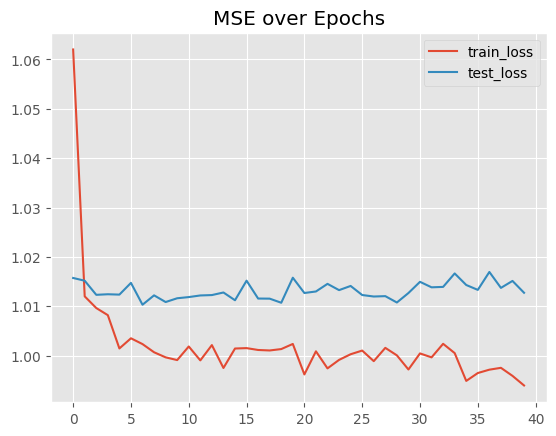

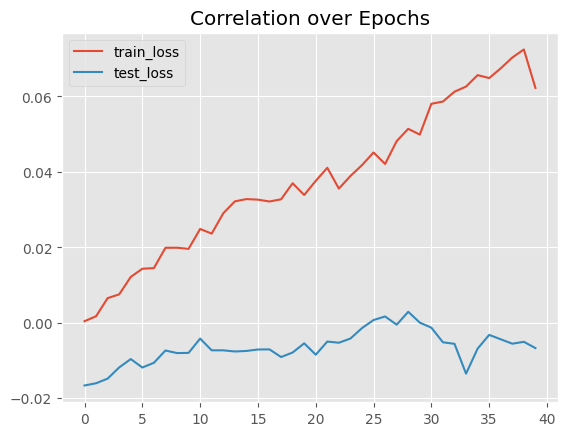

/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Results for weight decay equal to: 10
0.07264565471675609 0.08605051296082072


In [39]:
for i in range(len(list_weight_decay)):

    z = dic_data['noise1']['d_cond']
    z.get_dataloader(n_rolling=10, roll_y=True)

    m = AlternatingDualAttentionTransformer(10, 10, 10, mask=mask, d_model=64, dim_feedforward=64*4, dropout=0.2, nhead=8, num_layers=2, roll_y=True).to(device)
    optimizer = torch.optim.AdamW(m.parameters(), lr=0.001, weight_decay=list_weight_decay[i])
    m = torch.compile(m, backend="eager")

    model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer, device=device)
    model_torch.fit(z.train, test=z.test, epochs=40, plot=True)

    comp = benchmark_comparison.Comparator(models=[model_torch], model_names=['model_torch'])
            
    out_train = comp.correl(z, mode="train", return_values=True).loc["model_torch", "optimal"]
    out_test = comp.correl(z, mode="test", return_values=True).loc["model_torch", "optimal"]
    print("Results for weight decay equal to:", list_weight_decay[i])
    print(out_train, out_test)

### Loop over all the effects

In [42]:
effects = list(dic_data['noise1'].keys())

In [43]:
effects

['d_cond', 'd_shift', 'd_cs', 'd_cs_shift', 'd_all']

100%|██████████| 40/40 [00:36<00:00,  1.10it/s]


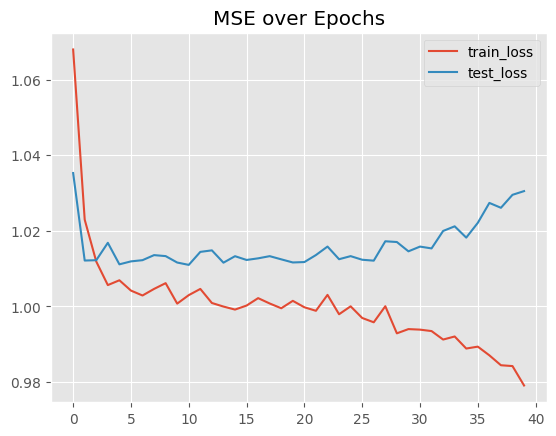

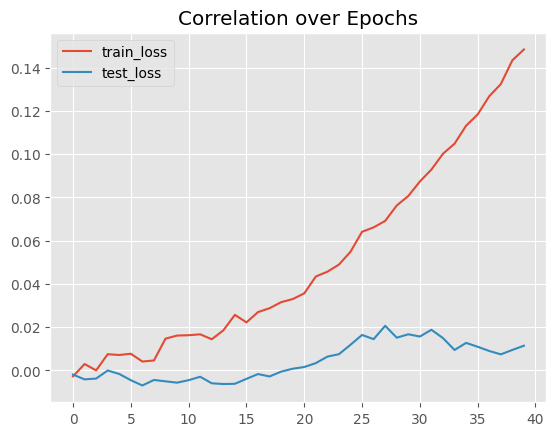

/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Results for  d_cond
0.16411803329691088 0.14853437202533212


100%|██████████| 40/40 [00:35<00:00,  1.14it/s]


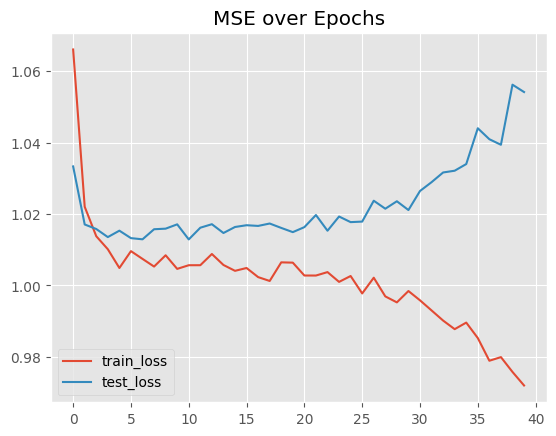

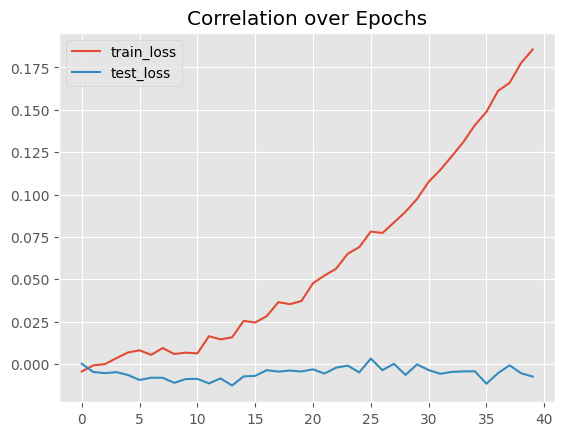

/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Results for  d_shift
0.049860436588135375 0.03843987598948578


100%|██████████| 40/40 [00:35<00:00,  1.11it/s]


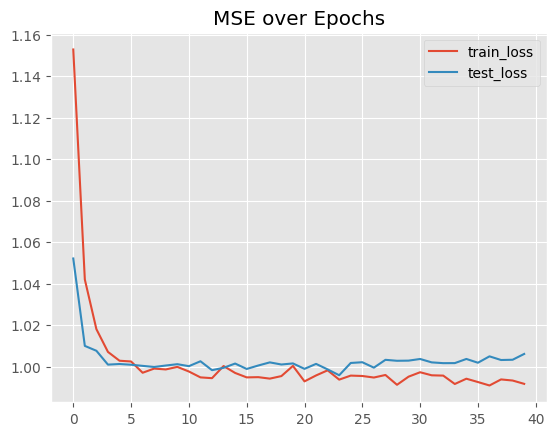

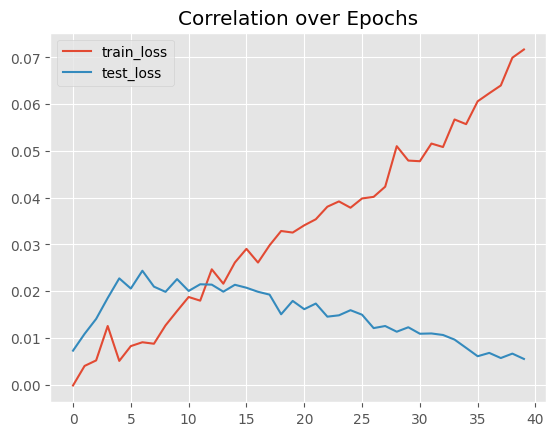

/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Results for  d_cs
0.00861745306186761 0.02581469633759969


100%|██████████| 40/40 [00:35<00:00,  1.13it/s]


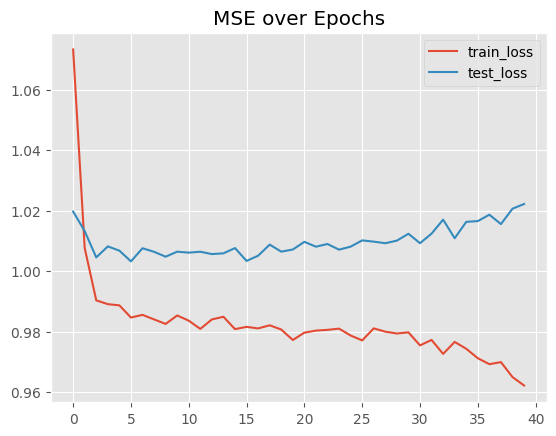

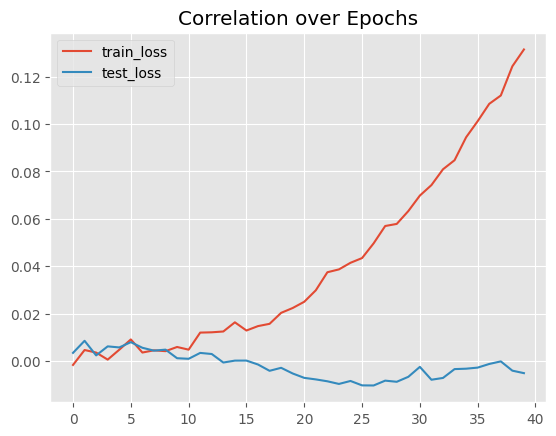

/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Results for  d_cs_shift
-0.0022422620244527762 -0.008196073170810126


100%|██████████| 40/40 [00:35<00:00,  1.13it/s]


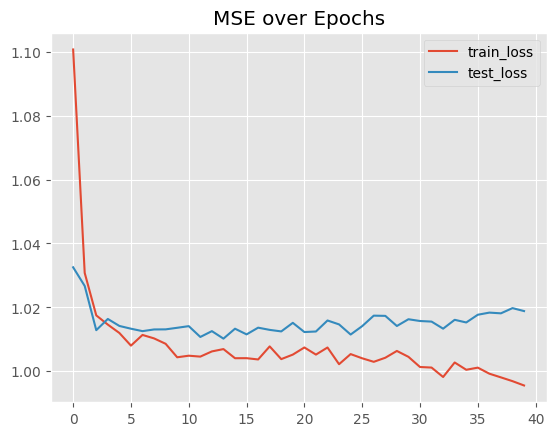

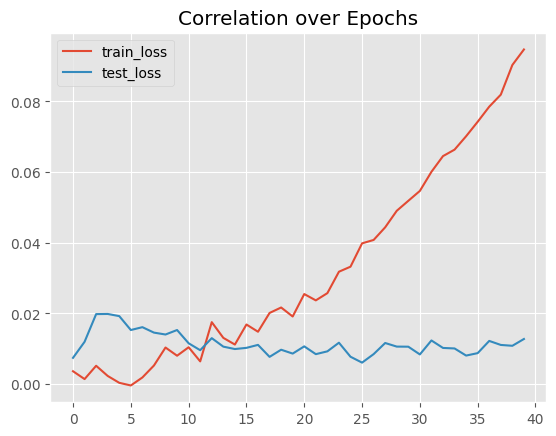

/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Results for  d_all
0.0784429316696076 0.0956576303216125


In [45]:
for ef in effects:

    z = dic_data['noise1'][ef]
    z.get_dataloader(n_rolling=10, roll_y=True)

    m = AlternatingDualAttentionTransformer(10, 10, 10, mask=mask, d_model=64, dim_feedforward=64*4, dropout=0.2, nhead=8, num_layers=2, roll_y=True).to(device)
    optimizer = torch.optim.AdamW(m.parameters(), lr=0.001, weight_decay=0.2)
    m = torch.compile(m, backend="eager")

    model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer, device=device)
    model_torch.fit(z.train, test=z.test, epochs=40, plot=True)

    comp = benchmark_comparison.Comparator(models=[model_torch], model_names=['model_torch'])
            
    out_train = comp.correl(z, mode="train", return_values=True).loc["model_torch", "optimal"]
    out_test = comp.correl(z, mode="test", return_values=True).loc["model_torch", "optimal"]
    print("Results for ", ef)
    print(out_train, out_test)

# Custom dual-attention

In [69]:
# Here we give a model where we can easily specify the ordering of time series and cross section attention blocks.

In [93]:
class CustomDualAttentionTransformer(nn.Module):
    def __init__(
        self,
        n_ts,
        n_f,
        n_rolling,
        mask,
        d_model=128,
        nhead=8,
        layers="TCTC",           
        dim_feedforward=512,
        dropout=0.1,
        sparsify=None,
        roll_y=False
    ):
        super().__init__()
        self.d_model = d_model
        self.n_rolling = n_rolling
        self.n_ts = n_ts
        self.mask = mask
        self.sparsify = sparsify
        self.roll_y = roll_y
        self.layers = layers          

        self.input_proj = nn.Linear(n_f, d_model)

        # Broadcasted positional embeddings
        self.pos_emb_time = nn.Parameter(torch.randn(1, 1, d_model))
        self.pos_emb_series = nn.Parameter(torch.randn(1, 1, d_model))
        self.dropout = nn.Dropout(dropout)

        self.blocks = nn.ModuleList()
        for symbol in layers:
            if symbol == 'T':   
                temporal_encoder = transformers.TransformerEncoder(
                    transformers.TransformerEncoderLayer(
                        d_model, nhead, dim_feedforward, dropout
                    ),
                    num_layers=1
                )
                self.blocks.append(nn.ModuleDict({
                    'temporal': temporal_encoder,
                    'norm': nn.LayerNorm(d_model),
                }))
            elif symbol == 'C': 
                series_layer = transformers.TransformerEncoderLayer(
                    d_model, nhead, dim_feedforward, dropout
                )
                self.blocks.append(nn.ModuleDict({
                    'series': series_layer,
                    'norm': nn.LayerNorm(d_model),
                }))
            else:
                raise ValueError(f"Invalid character in layers string: '{symbol}'. Only 'T' and 'C' are allowed.")

        self.output_head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, 1)
        )

    def series_attention(self, x, attn_layer):
        """Cross-sectional attention: attend over the N series dimension independently for each (B,T)"""
        B, T, N, D = x.shape
        x_flat = x.view(B * T, N, D)
        out = attn_layer.self_attn(x_flat, x_flat, x_flat)
        out = out.view(B, T, N, D)
        return out

    def temporal_attention(self, x, attn_encoder):
        """Temporal attention: attend over the T time dimension independently for each series"""
        B, T, N, D = x.shape
        x_flat = x.transpose(1, 2).contiguous().view(B * N, T, D)
        out = attn_encoder(x_flat, mask=self.mask, sparsify=self.sparsify)
        out = out.view(B, N, T, D).transpose(1, 2)
        return out

    def forward(self, x):
        # x: (B, T, N, F)
        B, T, N, _ = x.shape
        x = self.input_proj(x)

        # Add learnable positional embeddings (broadcasted over B, T, N)
        x = x + self.pos_emb_time + self.pos_emb_series
        x = self.dropout(x)

        # Process each block
        for block in self.blocks:
            res = x

            if 'temporal' in block:
                # Temporal block
                x_att = self.temporal_attention(x, block['temporal'])
                x = block['norm'](res + self.dropout(x_att).contiguous())

            elif 'series' in block:
                # Cross-sectional block
                x_att = self.series_attention(x, block['series'])
                x = block['norm'](res + self.dropout(x_att).contiguous())

        if not self.roll_y:
            x = x[:, -1, :, :]   # Take last time step for forecasting

        return self.output_head(x).squeeze(-1)

In [94]:
def causal_mask(b, h, q_idx, kv_idx):
    return q_idx >= kv_idx

def build_attention_mask(mask_fn, seq_len, device="cpu"):
    q_idx = torch.arange(seq_len, device=device)
    kv_idx = torch.arange(seq_len, device=device)
    b = torch.zeros(1, device=device)
    h = torch.zeros(1, device=device)
    mask_bool = mask_fn(b, h, q_idx[:, None], kv_idx[None, :])  # (seq_len, seq_len)
    return mask_bool

mask = causal_mask
mask = build_attention_mask(mask, 10, device=device)
def custom_mask_mod(b, h, q_idx, kv_idx):
    return mask[q_idx, kv_idx]

In [95]:
# Function used to make the attention matrix sparse

def keep_topk_per_row(x, k=2):
    vals, idx = torch.topk(x, k=k, dim=-1, largest=True)
    out = torch.zeros_like(x)
    out.scatter_(-1, idx, 1)
    return out

In [96]:
device='mps'

In [97]:
dic_data['noise1'].keys()

dict_keys(['d_cond', 'd_shift', 'd_cs', 'd_cs_shift', 'd_all'])

100%|██████████| 60/60 [01:38<00:00,  1.64s/it]


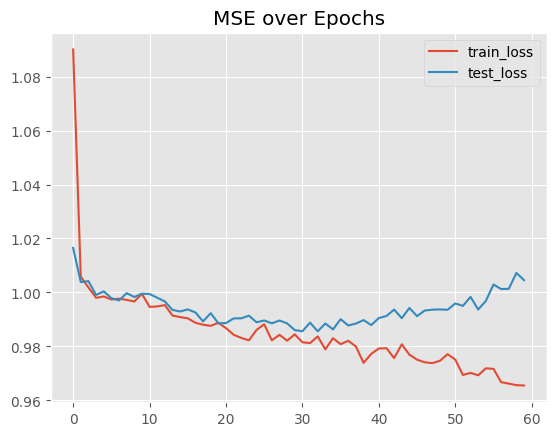

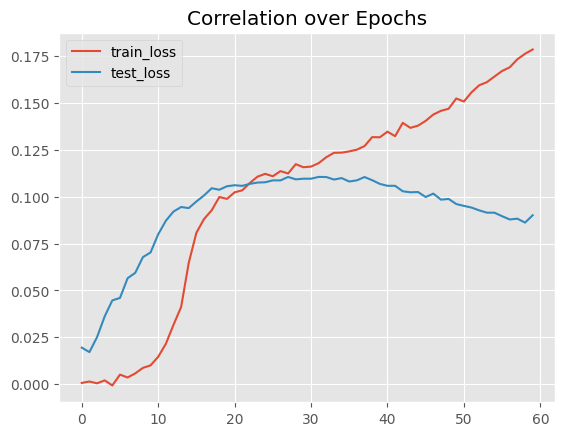

/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


0.09058906729801923 0.07146444062211015


In [107]:
z = dic_data['noise4']['d_cs_shift']
z.get_dataloader(n_rolling=10, roll_y=True)

m = CustomDualAttentionTransformer(10, 10, 10, mask=mask, d_model=64, dim_feedforward=64*4, dropout=0.2,
                                         nhead=8, layers="TCTCTCTC", roll_y=True).to(device)
optimizer = torch.optim.AdamW(m.parameters(), lr=0.001, weight_decay=0.1)
m = torch.compile(m, backend="eager")

model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer, device=device)
model_torch.fit(z.train, test=z.test, epochs=60, plot=True)

comp = benchmark_comparison.Comparator(models=[model_torch], model_names=['model_torch'])
        
out_train = comp.correl(z, mode="train", return_values=True).loc["model_torch", "optimal"]
out_test = comp.correl(z, mode="test", return_values=True).loc["model_torch", "optimal"]
 
print(out_train, out_test)